In [1]:
import os
from rosemary import jpt_setup; jpt_setup()

import matplotlib.pyplot as plt


from transformers.trainer_utils import get_last_checkpoint

import re
from llm.submit import (
    multiline_to_singleline,
    submit_job_ccc,
    submit_job_aimos,
    submit_job,
        get_run_statistics)
import pandas as pd
pd.set_option('display.max_colwidth', None)

import numpy as np
import json
import tempfile
import subprocess
import shlex
import datetime
import itertools
import glob

import base64
string_to_alphanumeric = lambda s: base64.urlsafe_b64encode(s.encode('utf-8')).decode('utf-8')
alphanumeric_to_string = lambda a: base64.urlsafe_b64decode(a).decode('utf-8')

from llm.submit import shell_scripts_template_slurm, shell_scripts_template_lsf, get_host_info, move_lsf_job_summary_to_save_dir
from note_pruning_analysis import open_instruct_dir, assets_dir
os.makedirs(assets_dir, exist_ok=True)

import getpass

queue = None if getpass.getuser() in ('PTFMqngp', 'wpq') else 'alt_7d'
info = get_host_info()
info.update({'queue': queue})
arch, cluster = info['arch'], info['cluster']
print(info)

os.environ['TORCHELASTIC_ERROR_FILE'] = os.path.join(os.getcwd(), 'torchelastic_error_file') 

## jobs submitted in notebook inherits env variables.
cache_dir = os.path.normpath(os.path.join(os.getcwd(), '../../../../mitibm2023/cache')) \
    if arch == 'ppc64le' else '/dccstor/data-pruning/cache'
os.environ['WANDB_DIR'] = cache_dir
os.makedirs(os.environ['WANDB_DIR'], exist_ok=True, mode=0o777)
os.environ['WANDB_MODE'] = 'offline'
os.environ['WANDB_PROJECT'] = 'mitibm'
##
##

shell_scripts_template = shell_scripts_template_slurm \
    if arch == 'ppc64le' else shell_scripts_template_lsf

/dccstor/data-pruning/wpq/github/mitibm2023/external/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


/dccstor/data-pruning/miniconda3/envs/open-instruct/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'arch': 'x86_64', 'cluster': 'ccc', 'queue': 'alt_7d'}


# DPO

In [4]:
queue = None if getpass.getuser() in ('PTFMqngp', 'wpq') else 'alt_7d'

from llm.submit import shell_scripts_template_slurm
debug = False
if debug:
    os.environ['TORCH_CPP_LOG_LEVEL'] = 'INFO'
    os.environ['NCCL_DEBUG'] = 'INFO'
else:
    os.environ['TORCH_CPP_LOG_LEVEL'] = 'WARNING'
    os.environ['NCCL_DEBUG'] = ''
num_cpus = 144 if arch == 'ppc64le' else 32
cpu_mem =  650 if arch == 'ppc64le' else 64

preprocessing_num_workers = 32
report_to = 'wandb'
mixed_precision = 'bf16' if arch == 'x86_64' else 'fp16'
torch_dtype = 'bfloat16' if arch=='x86_64' else 'float32'
gradient_checkpointing = True
use_fast_tokenizer = True
hf_models_dir = 'results/baselines/'
resume_from_checkpoint = True # resume from latest checkpoint if exists, otherwise train from scratch
num_train_epochs = 2
checkpointing_steps = 300 # (50_000 / 32) * 2 / 6 ~= 500 (data size of 50k, bsz=32, ep=2, total save 6 times at most)
max_train_steps = None
subsample_inds_file_list = [None]
dataloader_sampler = 'RandomSampler'
overwrite_cache = True


# #####
# job_name = 'dpo1'

# # model_name_or_path = hf_models_dir+'huggyllama/llama-7b'; abbr_model_name = 'llama-7b'; max_seq_length = 2048
# model_name_or_path = hf_models_dir+'EleutherAI/pythia-410m-deduped'; max_seq_length = 2048; abbr_model_name = 'pythia-410m'
# # model_name_or_path = 'results/oi2/llama-7b_sharegptv2_ep=2'; max_seq_length = 2048; abbr_model_name = 'llama-7b+sharegptv2ep2'

# train_file = 'data/processed/ultrafeedback/ultrafeedback_data.jsonl'; dataset = 'ultrafeedback'
# #####


#####
model_name_or_path = 'results/oi2/llama-7b_sharegptv2_ep=2'; max_seq_length = 2048; abbr_model_name = 'llama-7b+sharegptv2ep2'
# train_file = 'data/processed/ultrafeedback/ultrafeedback_data.jsonl'; dataset = 'ultrafeedback'
train_file = 'data/processed/hh_rlhf/hh_rlhf_data.jsonl'; dataset = 'hh_rlhf'

# M = 60_000; pacing_fn_list = [f'prune_size={M}_ep=3']; subset_size = 20_000
# M = 50_000; pacing_fn_list = [f'prune_size={M}_ep=5']; subset_size = 10_000
# M = 20_000; pacing_fn_list = [f'prune_size={M}_ep=4']; subset_size = 5_000
# M = 10_000; pacing_fn_list = [f'prune_size={M}_ep=10']; subset_size = 1_000
pacing_fn_list = [f'prune_size={M}_ep={ep}' for M, ep in [
    (10_000, 10), # 1k
#     (30_000, 3),  # 10k
#     (60_000, 3),  # 20k
]]

gen_output_md = 'llama7br512p4096'
# gen_output_md = 'llama7b+sharegptv2ep2+r512p4096'
# gen_output_model_name = 'all-mpnet-base-v2'

scoring_fn_list = []
scoring_fn_list += ['random_s=0']
# scoring_fn_list += ['random_s=1']
scoring_fn_list += [ 
#     f'dppmap_k=vmf_gamma=1_kmd={gen_output_md}_kemb=grad+rp+loraB',
#     f'dppmap_k=rbf_gamma=1e-3_kmd={gen_output_md}_kemb=text+embedding',
#     f'dppmap_k=rbf_gamma=1_kmd=mpnet_kemb=text+embedding',
]
scoring_fn_and_pacing_fn = list(itertools.product(scoring_fn_list, pacing_fn_list))


job_name = f'dpo2_{dataset}:{abbr_model_name}'
    

#####


####



#####
test_run = 1
test_run = bool(test_run)

nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 6
# nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 12
# nodes = 2; num_gpus = 1; gpu_type = 'v100'; job_duration = 6; cpu_mem = 100; num_cpus = 32; max_train_steps = 5; checkpointing_steps = 2; report_to = 'tensorboard'
    
#####


if scoring_fn_and_pacing_fn is not None: # pruning runs. 
    print('Set up data pruning runs. epochs=1, sampler=SequentialSampler, and `subsampe_inds_file`')
    num_train_epochs = 1 # offload handling of epochs to `generate_curriculum`
    dataloader_sampler = 'SequentialSampler'
    subsample_inds_file_list = []
    for scoring_fn, pacing_fn in scoring_fn_and_pacing_fn:
        from note_pruning import get_final_model_name
        from note_pruning_analysis import get_full_model_name, curriculum_dir
        gen_output_model_name = get_final_model_name(get_full_model_name(gen_output_md), scoring_fn)
        print(json.dumps({'scoring_fn': scoring_fn, 'gen_output_md': gen_output_md, 'gen_output_model_name': gen_output_model_name}, indent=4))
        p = os.path.join(curriculum_dir, gen_output_model_name, dataset, scoring_fn, 'inds_'+pacing_fn+'.pkl')
        if not os.path.isfile(p):
            raise ValueError(f'path={p} does not exists for {scoring_fn}')
        subsample_inds_file_list.append(p)

if not os.path.isfile(train_file):
    print(f'train_file={train_file} does not exists')

use_deepspeed = True
deepspeed_config_file = 'ds_configs/stage3_no_offloading_accelerate.conf'

per_device_train_batch_size = 1; total_batch_size = 32
gradient_accumulation_steps = round(total_batch_size/(num_gpus*nodes)/per_device_train_batch_size)
effective_batch_size = per_device_train_batch_size*nodes*num_gpus*gradient_accumulation_steps

print(f"Training {model_name_or_path} "
      f"using {num_gpus} GPUs, "
      f"{per_device_train_batch_size} batch size per GPU, "
      f"{gradient_accumulation_steps} gradient accumulation steps, "
      f"{effective_batch_size} effective batch size.")

# reference: https://gist.github.com/pacman100/1cb1f17b2f1b3139a63b764263e70b25
launcher = f"""accelerate launch \
    --mixed_precision {mixed_precision} \
    --num_machines {nodes} \
    --num_processes {num_gpus*nodes} \
    {'--use_deepspeed' if use_deepspeed else ''} \
    {'--deepspeed_config_file '+deepspeed_config_file if use_deepspeed else ''} \
    {'--main_process_ip $master_addr' if use_deepspeed else ''} \
    {'--main_process_port $master_port' if use_deepspeed else ''} \
    {'--machine_rank $SLURM_PROCID' if use_deepspeed else ''} \
    {'--rdzv_backend c10d' if use_deepspeed and nodes>1 else ''} \
    {'--deepspeed_multinode_launcher standard' if use_deepspeed and nodes>1 else ''} \
"""

cmds = []


options_list = itertools.product(
    subsample_inds_file_list,
)

output_dirname_list = []
for (subsample_inds_file,) in options_list:

    output_dirname = f"{abbr_model_name}_{dataset}"
    if any(job_name == y for y in ['dpo1']):
        output_dirname += f'_ep={num_train_epochs}'
    if test_run:
        output_dirname = 'jpt_'+output_dirname

    if subsample_inds_file:
        assert(num_train_epochs==1)
        def subsample_inds_file_abbr_fn(x):
            s = os.path.basename(x).split('.pkl')[0]
            if s.startswith('inds_'):
                scoring_fn = os.path.basename(os.path.dirname(x)).replace('_', ':')
                pacing_fn = s.split('inds_')[-1].replace('_', ':')
                s = f'score={scoring_fn}_pace={pacing_fn}'
            return s
        subsample_inds_file_abbr = subsample_inds_file_abbr_fn(subsample_inds_file)
        if subsample_inds_file_abbr:
            output_dirname += f'_{subsample_inds_file_abbr}'

    if subsample_inds_file is not None:
        assert(dataloader_sampler=='SequentialSampler')
        assert(num_train_epochs==1)
    else:
        assert(dataloader_sampler=='RandomSampler')

    output_dir = os.path.join('results', job_name, output_dirname)
    os.makedirs(os.path.join('results', job_name), exist_ok=True)
    wandb_run_name = output_dir.replace('results/', '')


    cmd = f"""
    {f'cd .. && CUDA_VISIBLE_DEVICES={os.environ["CUDA_VISIBLE_DEVICES"]} ' if test_run else ''}{launcher}
        open_instruct/dpo_tune.py \
        --model_name_or_path {model_name_or_path} \
        --tokenizer_name {model_name_or_path} \
        {'--use_slow_tokenizer' if not  use_fast_tokenizer else ''} \
        {'--gradient_checkpointing' if gradient_checkpointing  else ''} \
        --train_file {train_file} \
        --max_seq_length {max_seq_length} \
        {'--subsample_inds_file '+subsample_inds_file if subsample_inds_file else ''} \
        --dataloader_sampler {dataloader_sampler} \
        --preprocessing_num_workers {preprocessing_num_workers} \
        --per_device_train_batch_size {per_device_train_batch_size} \
        --gradient_accumulation_steps {gradient_accumulation_steps} \
        --learning_rate 5e-7 \
        --lr_scheduler_type linear \
        --warmup_ratio 0.1 \
        --weight_decay 0. \
        --num_train_epochs {num_train_epochs} \
        --with_tracking \
        {'--report_to "'+str(report_to)+'"' if report_to else ''} \
        --checkpointing_steps {checkpointing_steps} \
        {'--max_train_steps '+str(max_train_steps) if max_train_steps else ''} \
        {'--resume_from_checkpoint' if resume_from_checkpoint else ''} \
        {'--low_cpu_mem_usage' if not use_deepspeed else ''} \
        {'--overwrite_cache' if overwrite_cache else ''} \
        --logging_steps 1 \
        --output_dir {output_dir}
    """
    # if test_run:
    #     print('\n'+' \\\n\t'.join([x.strip() for x in re.split(r'\s{3,}', cmd)]))

    cmd = multiline_to_singleline(cmd)
    cmds.append(cmd)

    if test_run:
        print(cmd)

    shell_scripts = shell_scripts_template.format(
        conda_env='open-instruct',
        cwd=os.path.dirname(os.getcwd()),
        cmd=cmd,
        log_dir=os.getcwd(),
        save_dir=output_dir
    )
    if arch == 'x86_64': # ccc
        shell_scripts = re.sub('~/.profile', '/dccstor/data-pruning/.profile', shell_scripts)
    out = submit_job(
        shell_scripts, 
        job_name=job_name, 
        nodes=nodes,
        num_cpus=num_cpus,
        cpu_mem=cpu_mem,
        num_gpus=num_gpus,
        gpu_type=gpu_type,
        test_run=test_run,
        job_duration=job_duration,
        queue=queue,
    )
    if not test_run:
        print(out)

Set up data pruning runs. epochs=1, sampler=SequentialSampler, and `subsampe_inds_file`
{
    "scoring_fn": "random_s=0",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
{
    "scoring_fn": "dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb=grad+rp+loraB",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
{
    "scoring_fn": "dppmap_k=rbf_gamma=1e-3_kmd=llama7br512p4096_kemb=text+embedding",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
Training results/oi2/llama-7b_sharegptv2_ep=2 using 6 GPUs, 1 batch size per GPU, 1 gradient accumulation steps, 30 effective batch size.

Submiting job with:
{
    "job_name": "dpo2_ultrafeedback:llama-7b+sharegptv2ep2",
    "nodes": 5,
    "num_cpus": 144,
    "cpu_mem": 650,
    "num_gpus": 6,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "

In [ ]:

# prune: {1k@10, 10k@3}, datasets={dolly, stanford_alpaca}, scoring={random, dppmapx2}
# need to gen curriculum for 50k sft datasets

In [90]:
with open('gen_cmds_dpo.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[-1]
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

In [42]:
!bash gen_cmds_dpo.sh


+ CUDA_VISIBLE_DEVICES=5
+ cd ..
+ CUDA_VISIBLE_DEVICES=2,5
+ accelerate launch --mixed_precision fp16 --num_machines 1 --num_processes 2 --use_deepspeed --deepspeed_config_file ds_configs/stage3_no_offloading_accelerate.conf open_instruct/dpo_tune.py --model_name_or_path results/baselines/huggyllama/llama-7b --tokenizer_name results/baselines/huggyllama/llama-7b --gradient_checkpointing --train_file data/processed/ultrafeedback/ultrafeedback_data.jsonl --max_seq_length 2048 --preprocessing_num_workers 32 --per_device_train_batch_size 1 --gradient_accumulation_steps 16 --learning_rate 5e-7 --lr_scheduler_type linear --warmup_ratio 0.1 --weight_decay 0. --num_train_epochs 2 --with_tracking --report_to tensorboard --checkpointing_steps 500 --logging_steps 1 --output_dir results/dpo1/jpt_llama-7b_ultrafeedback
[2024-01-08 20:41:08,547] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
The following values were not passed to `accelerate launch` a

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32001. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
01/08/2024 20:42:20 - INFO - accelerate.accelerator - Updating DeepSpeed's gradient accumulation steps to 16 from 1.
[2024-01-08 20:42:20,382] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.10.1+23a11a39, git-hash=23a11a39, git-branch=master
01/08/2024 20:42:20 - INFO - torch.distributed.distributed_c10d - Added key: store_based_barrier_key:2 to store for rank: 0
01/08/2024 20:42:20 - INFO - torch.distributed.distributed_c10d - Added key: store_based_barrier_key:2 to store for rank: 1
01/08/2024 20:42:20 - INFO - torch.distri

ERROR:torch.distributed.elastic.multiprocessing.api:failed (exitcode: 1) local_rank: 0 (pid: 409110) of binary: /gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/bin/python3.10
Traceback (most recent call last):
  File "/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/bin/accelerate", line 8, in <module>
    sys.exit(main())
  File "/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/accelerate/commands/accelerate_cli.py", line 45, in main
    args.func(args)
  File "/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/accelerate/commands/launch.py", line 964, in launch_command
    deepspeed_launcher(args)
  File "/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/accelerate/commands/launch.py", line 687, in deepspeed_launcher
    distrib_run.run(args)
  File "/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/torch/di

# Finetuning with openinstruct/finetune_trainer.py


In [304]:
queue = None if getpass.getuser() in ('PTFMqngp', 'wpq') else 'alt_7d'
add_hardwarespec_to_dirname = False
save_strategy = 'steps'
save_steps = 200 if getpass.getuser() in ('PTFMqngp', 'wpq') else 1_000_000
save_total_limit = 1
preprocessing_num_workers = 32
evaluation_strategy = 'no' # set do_eval=False
eval_steps = save_steps
report_to = 'tensorboard wandb'
suffix = None
lr_scheduler_type = 'linear'
warmup_ratio = 0.03
dataloader_sampler = None
hf_models_dir = 'results/baselines/'
subsample_inds_file_list = [None]
max_train_samples_list = [None]
num_train_epochs_list = [1]
scoring_fn_and_pacing_fn = None


# ########### sft baselines


# job_name = 'oi2'; num_train_epochs_list = [3]
# # model_name_or_path = hf_models_dir+'mistralai/Mistral-7B-v0.1'; abbr_model_name = 'mistral-7b'; max_seq_length = 2048
# model_name_or_path = hf_models_dir+'huggyllama/llama-7b'; abbr_model_name = 'llama-7b'; max_seq_length = 2048

# # train_file = 'data/processed/flan_v2/flan_v2_data.jsonl'; abbr_train_file = 'flan_v2';
# # train_file = 'data/processed/dolly/dolly_data.jsonl'; abbr_train_file = 'dolly';
# # train_file = 'data/processed/stanford_alpaca/stanford_alpaca_data.jsonl'; abbr_train_file = 'stanford_alpaca'; 
# # train_file = 'data/processed/oasst1/oasst1_data.jsonl'; abbr_train_file = 'oasst1';
# # train_file = 'data/processed/wizardlm/wizardlmv2_data.jsonl'; abbr_train_file = 'wizardlmv2'; max_train_samples_list=[100_000]
# # train_file = 'data/processed/sharegpt/sharegptv2_data.jsonl'; abbr_train_file = 'sharegptv2'
# # train_file = 'data/processed/ultrachat/ultrachat200kv2_train_data.jsonl'; abbr_train_file = 'ultrachat200kv2'; max_train_samples_list=[100_000]

# ## 50k sft datasets
# # train_file = 'data/processed/dolly/dolly_data.jsonl'; abbr_train_file = 'dolly';
# # train_file = 'data/processed/stanford_alpaca/stanford_alpaca50k_data.jsonl'; abbr_train_file = 'stanford_alpaca50k'; 
# # train_file = 'data/processed/sharegpt/sharegpt50k_data.jsonl'; abbr_train_file = 'sharegpt50k'
# # train_file = 'data/processed/ultrachat/ultrachat50k_train_data.jsonl'; abbr_train_file = 'ultrachat50k'

# ## additional ones : {wizardlm50k, oasst2, lima, gpt4_alpaca50k, flan_v250k}
# # train_file = 'data/processed/wizardlm/wizardlm50k_data.jsonl'; abbr_train_file = 'wizardlm50k'
# # train_file = 'data/processed/oasst/oasst2_data.jsonl'; abbr_train_file = 'oasst2';
# # train_file = 'data/processed/flan_v2/flan_v250k_data.jsonl'; abbr_train_file = 'flan_v250k';
# # train_file = 'data/processed/gpt4_alpaca/gpt4_alpaca50k_data.jsonl'; abbr_train_file = 'gpt4_alpaca'; 
# train_file = 'data/processed/lima/lima_data.jsonl'; abbr_train_file = 'lima'; num_train_epochs_list = [3]



# # train_file = 'data/processed/open_orca/open_orca_slim_data.jsonl'; abbr_train_file = 'openorcaslim'; max_train_samples_list=[100_000]
# # train_file = 'data/processed/tulu_v2/tulu_v2_data.jsonl'; abbr_train_file = 'tulu_v2'; max_train_samples_list=[100_000]
# ###########


############ pruning runs

# model_name_or_path = hf_models_dir+'mistralai/Mistral-7B-v0.1'; abbr_model_name = 'mistral-7b'; max_seq_length = 2048; gen_output_md = 'mistral7br512p4096'
model_name_or_path = hf_models_dir+'huggyllama/llama-7b'; abbr_model_name = 'llama-7b'; max_seq_length = 2048; gen_output_md = 'llama7br512p4096'


# # 50k sft datasets
# dataset = 'flan_v250k'; train_file = 'data/processed/flan_v2/flan_v250k_data.jsonl'; abbr_train_file = 'flan_v250k';
# dataset = 'dolly'; train_file = 'data/processed/dolly/dolly_data.jsonl'; abbr_train_file = 'dolly';
# dataset = 'stanford_alpaca50k'; train_file = 'data/processed/stanford_alpaca/stanford_alpaca50k_data.jsonl'; abbr_train_file = 'stanford_alpaca50k'; 
# dataset = 'oasst2'; train_file = 'data/processed/oasst/oasst2_data.jsonl'; abbr_train_file = 'oasst2';
# dataset = 'wizardlm50k'; train_file = 'data/processed/wizardlm/wizardlm50k_data.jsonl'; abbr_train_file = 'wizardlm50k'
dataset = 'sharegpt50k'; train_file = 'data/processed/sharegpt/sharegpt50k_data.jsonl'; abbr_train_file = 'sharegpt50k'
# dataset = 'ultrachat50k'; train_file = 'data/processed/ultrachat/ultrachat50k_train_data.jsonl'; abbr_train_file = 'ultrachat50k'


# dataset = 'flan_v2'; train_file = 'data/processed/flan_v2/flan_v2_data.jsonl'; abbr_train_file = 'flan_v2';
# dataset = 'dolly'; train_file = 'data/processed/dolly/dolly_data.jsonl'; abbr_train_file = 'dolly';
# dataset = 'stanford_alpaca'; train_file = 'data/processed/stanford_alpaca/stanford_alpaca_data.jsonl'; abbr_train_file = 'stanford_alpaca';
# dataset = 'oasst2'; train_file = 'data/processed/oasst/oasst2_data.jsonl'; abbr_train_file = 'oasst2';
# dataset = 'wizardlmv2'; train_file = 'data/processed/wizardlm/wizardlmv2_data.jsonl'; abbr_train_file = 'wizardlmv2';
# dataset = 'sharegptv2'; train_file = 'data/processed/sharegpt/sharegptv2_data.jsonl'; abbr_train_file = 'sharegptv2';
# dataset = 'ultrachat200kv2'; train_file = 'data/processed/ultrachat/ultrachat200kv2_train_data.jsonl'; abbr_train_file = 'ultrachat200kv2';


# dataset = 'oasst1'; train_file = 'data/processed/oasst/oasst1_data.jsonl'; abbr_train_file = 'oasst1';
# dataset = 'open_orca_slim'; train_file = 'data/processed/open_orca/open_orca_slim_data.jsonl'; abbr_train_file = 'openorcaslim'; 
# dataset = 'tulu_v2'; train_file = 'data/processed/tulu_v2/tulu_v2_data.jsonl'; abbr_train_file = 'tulu_v2';
        
# M = 80_000; pacing_fn_list = [f'prune_size={M}_ep=2']; subset_size = 40_000
# M = 40_000; pacing_fn_list = [f'prune_size={M}_ep=2']; subset_size = 20_000
# M = 30_000; pacing_fn_list = [f'prune_size={M}_ep=3']; subset_size = 10_000
# M = 20_000; pacing_fn_list = [f'prune_size={M}_ep=4']; subset_size = 5_000
# M = 10_000; pacing_fn_list = [f'prune_size={M}_ep=10']; subset_size = 1_000
pacing_fn_list = [
    f'prune_size={M}_ep={ep}' for M, ep in [
#         (10_000, 10), # -> 1k, 2%
        (30_000, 3),  # -> 10k, 20%
#         (60_000, 3),  # -> 20k, 40%
#         (90_000, 3),  # -> 30k, 60%
#         (120_000, 3),  # -> 40k, 80%
    ]
]
#         + [running] 10k prune size. 4 datasets, compare {vmf,rbf} x {text,grad}


        
kmd = 'llama7br512p4096'
scoring_fn_list = [
#     'random_s=0',
#     'random_s=1',
    'log_prob_neg', 'el2n_agg=mean', 'grad_loraB_l2n',
#     'ifd_neg', 'log_pmi_neg',
    'numtoks_input_neg', 'numtoks_output_neg', 'numtoks_total_neg',
#     f'dppmap_k=vmf_gamma=1_kmd=mpnet', #_kemb=text+embedding',
    ##
#     f'dppmap_k=rbf_gamma=1e-3_kmd={kmd}_kemb=text+embedding',
#     f'dppmap_k=vmf_gamma=1_kmd={kmd}_kemb=grad+rp+loraB',
    # added baseline
#     f'dppmap_k=vmf_gamma=10_kmd={kmd}_kemb=text+embedding',
#     f'dppmap_k=rbf_gamma=1e-2_kmd={kmd}_kemb=grad+rp+loraB',
    ## arccos kernel
#     'dppmap_k=acos0_kmd=llama7br512p4096_kemb=grad+rp+loraB',
#     'dppmap_k=acos1_kmd=llama7br512p4096_kemb=grad+rp+loraB',
]

scoring_fn_list += [ # vary kernel embedding model 
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd={kmd}_kemb=grad+rp+loraB'
#     for kmd in ['llama7br256p4096', 'llama7br512p4096', 'pythia1br512p4096']
]
scoring_fn_and_pacing_fn = list(itertools.product(scoring_fn_list, pacing_fn_list))


job_name = f'oi5_{dataset}:{abbr_model_name}'
############ 


    
# add_hardwarespec_to_dirname = True
# job_name += '_debug' # wpq debug
# max_train_samples_list=[128*2]


#############

test_run = 0
test_run = bool(test_run)
debug_mode = test_run

if arch == 'x86_64':
#     nodes = 1; num_gpus = 8; gpu_type = 'a100_80gb'; job_duration = 6
    nodes = 1; num_gpus = 4; gpu_type = 'a100_80gb'; job_duration = 6 
    num_cpus = int(128/8*num_gpus); cpu_mem = int(768/8*num_gpus); preprocessing_num_workers = 128 # tok takes quite a bit.
    per_device_train_batch_size = 1
    gradient_checkpointing = False
    mixed_precision = 'bf16'; torch_dtype = 'float32'; use_flash_attn = False; use_tf32 = True 
    save_model_torch_dtype = 'bfloat16' # typically save fp32 weights, but for disk space sake, convert to bf16.
else:
    nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 6
    num_cpus = int(128/6*num_gpus); cpu_mem = int(512/6*num_gpus)
    per_device_train_batch_size = 2
    gradient_checkpointing = True
    mixed_precision = 'fp16'; torch_dtype = 'float32'; use_flash_attn = False; use_tf32 = False
    save_model_torch_dtype = None



if scoring_fn_and_pacing_fn is not None: # pruning runs. 
    print('Set up data pruning runs. epochs=1, sampler=SequentialSampler, and `subsampe_inds_file`')
    num_train_epochs_list = [1] # offload handling of epochs to `generate_curriculum`
    dataloader_sampler = 'SequentialSampler'
    subsample_inds_file_list = []
    for scoring_fn, pacing_fn in scoring_fn_and_pacing_fn:
        from note_pruning import get_final_model_name
        from note_pruning_analysis import get_full_model_name, curriculum_dir
        gen_output_model_name = get_final_model_name(get_full_model_name(gen_output_md), scoring_fn)
        print(json.dumps({'scoring_fn': scoring_fn, 'gen_output_md': gen_output_md, 'gen_output_model_name': gen_output_model_name}, indent=4))
        p = os.path.join(curriculum_dir, gen_output_model_name, dataset, scoring_fn, 'inds_'+pacing_fn+'.pkl')
        if not os.path.isfile(p):
            raise ValueError(f'path={p} does not exists for {scoring_fn}')
        subsample_inds_file_list.append(p)

overwrite_output_dir = True if test_run else False # always continue from ckpt if run from cluster.

total_batch_size = 128
gradient_accumulation_steps = round(total_batch_size/(num_gpus*nodes)/per_device_train_batch_size)
effective_batch_size = per_device_train_batch_size*nodes*num_gpus*gradient_accumulation_steps

optimizer = 'adamw_hf'

deepspeed = ''; fsdp = False if num_gpus == 1 else "full_shard auto_wrap" 
if 'gpt2' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'GPT2Block'
elif 'llama' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'LlamaDecoderLayer'
elif 'mpt' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'MPTBlock'
elif 'pythia' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'GPTNeoXLayer'        
elif 'mistral' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'MistralDecoderLayer'
else: raise ValueError('Not sure how to set `fsdp_transformer_layer_cls_to_wrap`')
    
# deepspeed = './ds_configs/ds_zero3_cpu_offload.json'; fsdp = False
# deepspeed = './ds_configs/ds_zero3.json'; fsdp = False
# deepspeed = './ds_configs/stage3_no_offloading.conf'; fsdp = False # error with loading... something wrong with the config.
# fsdp = False; deepspeed = False

if fsdp and deepspeed:
    raise ValueError('either fsdp or deepspeed, not both')

use_lora = False
lora_rank = 256 
lora_alpha = lora_rank 
lora_dropout = 0.05
if use_lora:
    abbr_model_name += f'+lora(r={lora_rank},a={lora_alpha})'
load_in_8bit = False

print(f"Training {model_name_or_path} "
      f"using {num_gpus} GPUs, "
      f"{per_device_train_batch_size} batch size per GPU, "
      f"{gradient_accumulation_steps} gradient accumulation steps, "
      f"Effective batch size {effective_batch_size}")


if nodes == 1:
    exe = 'python' if num_gpus==1 else \
        f"torchrun --nnodes 1 --nproc_per_node={num_gpus} --rdzv_backend=c10d --rdzv_endpoint=localhost:0" # assigns random port. https://github.com/pytorch/pytorch/issues/73320
else:
    exe = f"torchrun --nnodes={nodes} --nproc_per_node={num_gpus} --rdzv-id=${'SLURM_JOB_ID' if arch == 'ppcle64' else 'LSB_JOBID'} --rdzv-backend=c10d --rdzv-endpoint=$RDZV_ENDPOINT"

if test_run:
    exe = f"CUDA_VISIBLE_DEVICES={','.join(map(str, range(num_gpus)))} {exe}"
if test_run and debug_mode:
    exe = 'TORCH_CPP_LOG_LEVEL=INFO NCCL_DEBUG=INFO LOGLEVEL=INFO ' + exe
    error_file = os.path.join(open_instruct_dir, 'scripts', 'error_file')
    exe = f'TORCHELASTIC_ERROR_FILE={error_file} {exe}'

if not os.path.isfile(train_file):
    print(f'train_file={train_file} does not exists')

options_list = itertools.product(
    num_train_epochs_list,
    subsample_inds_file_list,
    max_train_samples_list,
)

cmds = []
output_dirname_list = []
for (num_train_epochs,
     subsample_inds_file,
     max_train_samples,) in options_list:

    output_dirname = f"{abbr_model_name}_{abbr_train_file}"
    if max_train_samples:
        output_dirname += f":{int(max_train_samples/1000)}k"
            
    if any(job_name == y for y in ['oi2']):
        output_dirname += f'_ep={num_train_epochs}'
        
    if subsample_inds_file:
        def subsample_inds_file_abbr_fn(x):
            s = os.path.basename(x).split('.pkl')[0]
            if s.startswith('inds_'):
                scoring_fn = os.path.basename(os.path.dirname(x)).replace('_', ':')
                pacing_fn = s.split('inds_')[-1].replace('_', ':')
                return f'score={scoring_fn}_pace={pacing_fn}'
            else:
                return s
        subsample_inds_file_abbr = subsample_inds_file_abbr_fn(subsample_inds_file)
        if subsample_inds_file_abbr:
            output_dirname += f'_{subsample_inds_file_abbr}'
            
    if test_run:
        output_dirname = 'jpt_'+output_dirname
            
    if add_hardwarespec_to_dirname:
        output_dirname += \
            ('_fsdp='+fsdp.split(' ')[0] if fsdp else '')+\
            ('_deepspeed='+os.path.basename(deepspeed).split('.')[0] if deepspeed else '')+\
            ('_gradckpt='+str(gradient_checkpointing) if gradient_checkpointing else '')+\
            '_mbsz='+str(per_device_train_batch_size)+\
            ('_dtype='+torch_dtype if torch_dtype is not None else '')+\
            ('_mp='+str(mixed_precision) if mixed_precision else '_mp=none')+\
            '_seqlen='+str(max_seq_length)+\
            '_nodes='+str(nodes)+\
            '_ngpus='+str(num_gpus)+\
            ('_fa2' if use_flash_attn else '')
    if suffix:
        output_dirname += suffix
    output_dir = os.path.join(open_instruct_dir, 'results', job_name, output_dirname)
    os.makedirs(os.path.join(open_instruct_dir, 'results', job_name), exist_ok=True)
    if arch == 'x86_64':
        wandb_run_name = 'ccc'+output_dir[output_dir.find('results'):][7:] # e.g., ccc/oi2/run_name
    else:
        wandb_run_name = output_dir.replace('results/', '') # e.g., oi2/run_name
    

    cmd = f"""
    {'cd .. && ' if test_run else ''}{exe}
        open_instruct/finetune_trainer.py \
        --model_name_or_path={model_name_or_path} \
        --tokenizer_name={model_name_or_path} \
        {'--load_in_8bit' if load_in_8bit else ''} \
        --use_fast_tokenizer=True \
        --train_file={train_file} \
        --max_seq_length={max_seq_length} \
        {'--max_train_samples='+str(max_train_samples) if max_train_samples else ''} \
        {'--use_lora' if use_lora else ''} \
        {'--lora_rank='+str(lora_rank) if use_lora else ''} \
        {'--lora_alpha='+str(lora_alpha) if use_lora else ''} \
        {'--lora_dropout='+str(lora_dropout) if use_lora else ''} \
        --do_train \
        --preprocessing_num_workers={preprocessing_num_workers} \
        --per_device_train_batch_size={per_device_train_batch_size} \
        --gradient_accumulation_steps={gradient_accumulation_steps} \
        --learning_rate=2e-5 \
        --lr_scheduler_type={lr_scheduler_type} \
        --warmup_ratio={warmup_ratio} \
        --weight_decay=0. \
        --optim={optimizer} \
        --evaluation_strategy={evaluation_strategy} \
        {'--eval_steps='+str(eval_steps) if eval_steps else ''} \
        {'--report_to '+str(report_to) if report_to else ''} \
        --run_name {wandb_run_name} \
        --logging_strategy=steps \
        --logging_first_step \
        --logging_steps=1 \
        --save_strategy={save_strategy} \
        --save_steps={save_steps} \
        --save_total_limit={save_total_limit} \
        --num_train_epochs={num_train_epochs} \
        --ddp_timeout=7200 \
        {'--fsdp="'+fsdp+'"' if fsdp else ''} \
        {'--fsdp_transformer_layer_cls_to_wrap="'+fsdp_transformer_layer_cls_to_wrap+'"' 
            if fsdp else ''} \
        {'--gradient_checkpointing' if gradient_checkpointing  else ''} \
        {'--torch_dtype='+str(torch_dtype) if torch_dtype else ''} \
        {'--save_model_torch_dtype='+str(save_model_torch_dtype) if save_model_torch_dtype else ''} \
        --dataloader_num_workers=8 \
        {f'--{mixed_precision}=True' if mixed_precision else ''} \
        {f'--tf32=True' if use_tf32 else ''} \
        {'--overwrite_output_dir' if overwrite_output_dir else ''} \
        {'--deepspeed='+deepspeed if deepspeed else ''} \
        {'--subsample_inds_file='+subsample_inds_file if subsample_inds_file else ''} \
        {'--dataloader_sampler '+str(dataloader_sampler) if dataloader_sampler else ''} \
        --use_flash_attn {'True' if use_flash_attn else 'False'} \
        --low_cpu_mem_usage \
        --overwrite_cache \
        --output_dir="{output_dir}" \
    """ 
    #  --overwrite_cache   # if delete a dataset and need to refresh cache

    if test_run:
        print()
        print('\n'+' \\\n\t'.join([x.strip() for x in re.split(r'\s{3,}', cmd)]))

    cmd = multiline_to_singleline(cmd)
    cmds.append(cmd)

    shell_scripts = shell_scripts_template.format(
        conda_env='open-instruct',
        cwd=os.path.dirname(os.getcwd()),
        cmd=cmd,
        log_dir=os.getcwd(),
        save_dir=output_dir
    )
    if arch == 'x86_64':
        shell_scripts = re.sub('~/.profile', '/dccstor/data-pruning/.profile', shell_scripts)
    out = submit_job(
        shell_scripts, 
        job_name=job_name, 
        nodes=nodes,
        num_cpus=num_cpus,
        cpu_mem=cpu_mem,
        num_gpus=num_gpus,
        gpu_type=gpu_type,
        test_run=test_run,
        queue=queue,
        job_duration=job_duration,
    )
    if not test_run:
        print(out)

Set up data pruning runs. epochs=1, sampler=SequentialSampler, and `subsampe_inds_file`
{
    "scoring_fn": "log_prob_neg",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
{
    "scoring_fn": "el2n_agg=mean",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
{
    "scoring_fn": "grad_loraB_l2n",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
{
    "scoring_fn": "numtoks_input_neg",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
{
    "scoring_fn": "numtoks_output_neg",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
{
    "scoring_fn": "numtoks_total_neg",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
Train

[{'args': 'jbsub -queue alt_7d -name oi5_stanford_alpaca50k:llama-7b -mem 384g -cores 1x64+4 -require a100_80gb -out /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/scripts/%J.out bash -c \'echo "Running on $LSB_DJOB_HOSTFILE"; echo "======"; master_addr=$(head -n 1 "$LSB_DJOB_HOSTFILE"); master_port=10002; RDZV_ENDPOINT=$master_addr:$master_port; source /dccstor/data-pruning/.profile; conda activate open-instruct; cd /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct; set -e; set -x; echo "======"; torchrun --nnodes 1 --nproc_per_node=4 --rdzv_backend=c10d --rdzv_endpoint=localhost:0 open_instruct/finetune_trainer.py --model_name_or_path=results/baselines/huggyllama/llama-7b --tokenizer_name=results/baselines/huggyllama/llama-7b --use_fast_tokenizer=True --train_file=data/processed/stanford_alpaca/stanford_alpaca50k_data.jsonl --max_seq_length=2048 --do_train --preprocessing_num_workers=128 --per_device_train_batch_size=1 --gradient_accumulation_step

In [43]:
with open('gen_cmds_sft.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[-1]
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

In [44]:
!bash gen_cmds_sft.sh

+ CUDA_VISIBLE_DEVICES=0
+ cd ..
+ TORCHELASTIC_ERROR_FILE=/dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/scripts/error_file
+ TORCH_CPP_LOG_LEVEL=INFO
+ NCCL_DEBUG=INFO
+ LOGLEVEL=INFO
+ CUDA_VISIBLE_DEVICES=0
+ python open_instruct/finetune_trainer.py --model_name_or_path=results/baselines/huggyllama/llama-7b --tokenizer_name=results/baselines/huggyllama/llama-7b --use_fast_tokenizer=True --train_file=data/processed/oasst1/oasst1_data.jsonl --max_seq_length=2048 --do_train --preprocessing_num_workers=32 --per_device_train_batch_size=1 --gradient_accumulation_steps=128 --learning_rate=2e-5 --lr_scheduler_type=linear --warmup_ratio=0.03 --weight_decay=0. --optim=adamw_hf --evaluation_strategy=no --eval_steps=200 --report_to tensorboard wandb --run_name /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/oi5_oasst1:llama-7b_debug/jpt_llama-7b_oasst1_score=random:s=0_pace=prune:size=10000:ep=10 --logging_strategy=steps --logging_first_step --logging_ste

[INFO|modeling_utils.py:3118] 2024-01-19 02:04:39,229 >> loading weights file results/baselines/huggyllama/llama-7b/model.safetensors.index.json
[INFO|modeling_utils.py:1222] 2024-01-19 02:04:39,229 >> Instantiating LlamaForCausalLM model under default dtype torch.bfloat16.
[WARNING|modeling_utils.py:1304] 2024-01-19 02:04:39,230 >> You are attempting to use Flash Attention 2.0 with a model initialized on CPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
[INFO|configuration_utils.py:791] 2024-01-19 02:04:39,230 >> Generate config GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2,
  "pad_token_id": 0
}

Loading checkpoint shards: 100%|██████████████████| 2/2 [00:01<00:00,  1.07it/s]
[INFO|modeling_utils.py:3950] 2024-01-19 02:04:41,778 >> All model checkpoint weights were used when initializing LlamaForCausalLM.

[INFO|modeling_utils.py:3958] 2024-01-19 02:04:41,778 >> All the weights of LlamaForCausalLM were initialized from the mod

Spawning 32 processes
01/19/2024 02:04:52 - INFO - datasets.arrow_dataset - Spawning 32 processes
Tokenizing and reformatting instruction data (num_proc=32):   0%| | 0/33717 [00:Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_00000_of_00032.arrow
01/19/2024 02:04:52 - INFO - datasets.arrow_dataset - Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_00000_of_00032.arrow
Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_

Tokenizing and reformatting instruction data (num_proc=32):   3%| | 1001/33717 [Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_00014_of_00032.arrow
01/19/2024 02:04:52 - INFO - datasets.arrow_dataset - Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_00014_of_00032.arrow
Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_00015_of_00032.arrow
01/19/2024 02:04:52 - INFO - datasets.arrow_dataset - Caching processed datas

Tokenizing and reformatting instruction data (num_proc=32):  12%| | 4021/33717 [Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_00028_of_00032.arrow
01/19/2024 02:04:52 - INFO - datasets.arrow_dataset - Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_00028_of_00032.arrow
Caching processed dataset at /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-b03eccd42e843020/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-34d81440de676221_00029_of_00032.arrow
01/19/2024 02:04:52 - INFO - datasets.arrow_dataset - Caching processed datas

[wpq] Example 0 of train_dataset: 
{'dataset': 'oasst1', 'id': 'oasst1_20480', 'messages': [{'role': 'user', 'content': 'Cómo manejar un carro manual'}, {'role': 'assistant', 'content': 'Lo primero que tienes que hacer, si nunca has conducido un coche manual, es familiarizarte con el embrague y palanca de cambios. Si conduces habitualmente un coche automático, estarás acostumbrado a no utilizar para nada el pie izquierdo ni la palanca del cambio. Encontrarás tres pedales, siendo el embrague el que está situado a la izquierda y el que tendrás que pisar cada vez que cambies de marcha. Por otro lado, la palanca del cambio se ubica siempre en la consola central.\n\nPara arrancar un coche manual, es necesario seguir una serie de pasos que, al principio, pueden parecer muchos, pero que, con el tiempo, acabarás haciéndolos sin darte cuenta:\n\n1) Comprueba que la palanca del cambio está en punto muerto\n2) Coloca el pie derecho en el pedal del freno\n3) Arranca el motor\n4) Pisa el embrague c

[INFO|trainer.py:593] 2024-01-19 02:04:57,333 >> Using auto half precision backend
[INFO|trainer.py:738] 2024-01-19 02:04:57,494 >> The following columns in the training set don't have a corresponding argument in `LlamaForCausalLM.forward` and have been ignored: messages, id, dataset. If messages, id, dataset are not expected by `LlamaForCausalLM.forward`,  you can safely ignore this message.
/dccstor/data-pruning/miniconda3/envs/open-instruct/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[INFO|trainer.py:1723] 2024-01-19 02:04:57,514 >> ***** Running training *****
[INFO|trainer.py:1724] 2024-01-19 02:04:57,514 >>   Num examples = 10,000
[INFO|trainer.py:1725] 2024-01-19 02:04:57,514 >>   Num Epochs = 1
[INFO|trainer.py:1726] 2024-01-19 

KeyboardInterrupt: 

# eval



In [305]:
from gen_cmds_utils import remove_all_symlinks, create_unique_symlinks, get_chat_formatting_function, get_resource_for_task, OPENAI_MODEL_LIST


create_symlinks = False
include_checkpoints = False
eval_rest = True
subdir_path_list = []
subdir_filter_fn = lambda x: True
use_slow_tokenizer = True
launch_one_job_per_model = True

task_names = [
#     'mmlu_s=0',
    'mmlu_s=5', 
#     'gsm_s=8',
#     'gsm_s=8_cot',
#     'bbh_s=3',
#     'bbh_s=3_cot', # max_datapoints_per_task=40 -> 40min.
#     'humaneval',
#     'tydiqa_s=1_cb', # 3min
#     'tydiqa_s=1_gp',
    # 'toxigen', # ~1.5hr
#     'alpacafarm_ann=gpt35:turbo:1106',
    # 'alpacafarm_ann=chatgpt', # ~$1 per eval.
]
task_names_chatfmt = [x+'_chatfmt' for x in task_names]


task_names_mtbench = ['mtbench_ann=gpt:4:1106:preview_chatfmt'] # ann=gpt:4, ann=gpt:3.5:turbo:1106, gpt:4:1106:preview (gpt4-turbo)
# task_names_mtbench = ['mtbench_ann=gpt:3.5:turbo:1106_chatfmt'] # for debug sake, prefer gpt4
# task_names_mtbench = ['mtbench_ann=gpt:4_chatfmt']
# task_names_alpacafarm = ['alpacafarm_ann=chatgpt_chatfmt']
task_names_alpacafarm = ['alpacafarm_ann=alpaca:eval:gpt4:turbo:fn_chatfmt']
task_names_chateval = task_names_mtbench + task_names_alpacafarm


# # ## baselines eval 
# subdir_path_list = [os.path.join('results/baselines', x) for x in [
# #     'huggyllama/llama-7b', 
# #     'mistralai/Mistral-7B-v0.1',
# #     'mistralai/Mistral-7B-Instruct-v0.1',
# #     'NousResearch/Llama-2-7b-hf',
# #     'NousResearch/Llama-2-7b-chat-hf',
# #     'HuggingFaceH4/mistral-7b-sft-alpha',
# #     'HuggingFaceH4/mistral-7b-sft-beta',
# #     'HuggingFaceH4/zephyr-7b-alpha',
#     'HuggingFaceH4/zephyr-7b-beta',
# #     'codellama/CodeLlama-7b-hf',
# #     'codellama/CodeLlama-7b-Python-hf',
# #     'codellama/CodeLlama-7b-Instruct-hf',
# ]]
# # task_names = task_names + task_names_chatfmt
# task_names = task_names_mtbench

# # oi5
# exp_dir = 'results/oi2'
# exp_dir = 'results/oi5_flan_v2:llama-7b'
# exp_dir = 'results/oi5_dolly:llama-7b'
# exp_dir = 'results/oi5_wizardlm50k:llama-7b'
# exp_dir = 'results/oi5_sharegpt50k:llama-7b'
# exp_dir = 'results/oi5_oasst1:llama-7b'
# exp_dir = 'results/oi5_oasst1:llama-7b_debug'
# exp_dir = 'results/oi5_stanford_alpaca:llama-7b'
# exp_dir = 'results/oi5_wizardlmv2:llama-7b'
# exp_dir = 'results/oi5_sharegptv2:llama-7b'
# exp_dir = 'results/oi5_ultrachat200kv2:llama-7b'
# exp_dir = 'results/oi5_tulu_v2:llama-7b'
# exp_dir = 'results/oi5_open_orca_slim:llama-7b'
# exp_dir = 'results/dpo1'
# exp_dir = 'results/dpo2_ultrafeedback:llama-7b+sharegptv2ep2'
exp_dirs = [
#     'results/baselines/huggyllama',
    'results/oi2',
    'results/oi5_dolly:llama-7b',
    'results/oi5_flan_v250k:llama-7b',
    'results/oi5_stanford_alpaca50k:llama-7b',
    'results/oi5_oasst2:llama-7b',
    'results/oi5_wizardlm50k:llama-7b',
    'results/oi5_sharegpt50k:llama-7b',
    'results/oi5_ultrachat50k:llama-7b',
]
exp_dirs = [
    'results/dpo2_ultrafeedback:llama-7b+sharegptv2ep2',
]

# subdir_filter_fn = lambda x: 'text+embedding' in x
# subdir_filter_fn = lambda x: 'sharegpt' in x and 'prune:size=90000:ep=3' in x and ('vmf:gamma=10:kmd=llama7br512p4096:kemb=text+embedding' in x or 'vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB' in x)
task_names = task_names + task_names_chatfmt;
# task_names = ['alpacafarm_ann=alpaca:eval:gpt4_chatfmt']
# task_names = ['mtbench_ann=gpt:4_chatfmt'] 
# task_names = task_names_alpacafarm; 
# task_names = task_names_mtbench
# task_names = task_names + task_names_chatfmt + task_names_mtbench
# task_names = task_names
# task_names = ['alpacafarm_ann=gpt35:turbo:1106_chatfmt']


test_run = 1
test_run = bool(test_run)

num_gpus = 1
if arch == 'x86_64': # ccc
    gpu_type = 'a100_80gb'; num_cpus = int(128/8*num_gpus); cpu_mem = int(768/8*num_gpus)
    use_vllm = True; torch_dtype = 'bfloat16'
else:
    gpu_type = 'v100'
    num_cpus = int(128/6*num_gpus); cpu_mem = int(512/6*num_gpus)
    use_vllm = False; torch_dtype = 'float16'
    
    
if len(subdir_path_list)==0:
    subdir_path_list = []
    for exp_dir in exp_dirs:
        if create_symlinks:
            remove_all_symlinks(exp_dir)
        subdirs = list(os.listdir(exp_dir))
        subdirs = filter(subdir_filter_fn, subdirs)
        for subdir in subdirs:
            subdir_path = os.path.join(exp_dir, subdir)
            if include_checkpoints:
                subdir_path_list += glob.glob(os.path.join(subdir_path, 'checkpoint-*'))
            if not os.path.isfile(os.path.join(subdir_path, 'config.json')): # skip runs not yet finished
                continue
            subdir_path_list.append(subdir_path)

if eval_rest:
    task_name_and_model = []
    for subdir_path in subdir_path_list:
        for task_name in task_names:
            if not os.path.islink(subdir_path) and \
                not os.path.isfile(os.path.join(subdir_path, 'eval', task_name, 'metrics.json')):
                task_name_and_model.append((task_name, subdir_path))
                print((task_name, subdir_path))
else:
    task_name_and_model = list(itertools.product(task_names, subdir_path_list))
    

print('#cmds: ', len(list(task_name_and_model)), '\n')

if create_symlinks:
    # create symlink for each directory.
    symlink_path_dict = create_unique_symlinks(
        list([x[1] for x in task_name_and_model]))
    options_list = list(map(lambda x: (x[0], symlink_path_dict[x[1]]), task_name_and_model))
else:
    options_list = task_name_and_model
    
    
dfo = pd.DataFrame(options_list, columns=['task_name', 'model_name_or_path'])
model_and_task_list = dfo.groupby('model_name_or_path')['task_name'].agg(list).to_dict()


info = {}  
cmds = []
for model_name_or_path, task_name_list in model_and_task_list.items():
    num_tasks = len(task_name_list)
    cmds_per_model = []
    for i, task_name in enumerate(task_name_list):
        queue = None if getpass.getuser() in ('PTFMqngp', 'wpq') else \
            ('alt_7d' if task_name.startswith('mtbench') else 'alt_1h')

        use_chat_format = 'chatfmt' in task_name
        chat_formatting_function = get_chat_formatting_function(model_name_or_path)

        try:
            with open(os.path.join(model_name_or_path, 'ft_args.json'), 'r') as f:
                ft_args = json.load(f)
            # note `model_name_or_path` could be anything, e.g., soft links with arbitrary names.
            # but `ft_args_model_name_or_path` indicates the finetuned model name.
            if 'model_args' in ft_args:
                ft_args_model_name_or_path = ft_args['model_args']['model_name_or_path']
            else:
                ft_args_model_name_or_path = ft_args['model_name_or_path']
        except:
            ft_args_model_name_or_path = model_name_or_path

        batch_size, job_duration = get_resource_for_task(
            task_name, ft_args_model_name_or_path)

        job_name = f'eval.{task_name}'
        save_dir = f'{model_name_or_path}/eval/{task_name}'

        if task_name.startswith('mmlu'):
            match = re.search(r's=(\d+)', task_name)
            n_shot = int(match.group(1))
            assert(n_shot <= 5)
            cmd = f"""
            python -m eval.mmlu.run_eval \
                --data_dir data/eval/mmlu \
                --model_name_or_path "{model_name_or_path}" \
                --save_dir "{save_dir}" \
                --eval_batch_size {batch_size} \
                --ntrain {n_shot} \
                {'--use_chat_format' if use_chat_format else ''} \
                --chat_formatting_function {chat_formatting_function} \
                {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
                --torch_dtype {torch_dtype} \
            """
        elif task_name.startswith('gsm'):
            match = re.search(r's=(\d+)', task_name)
            n_shot = int(match.group(1))
            assert(n_shot <= 8)
            # open-instruct used 200 examples. use higher amount to get a more accurate number
            cmd = f"""
            python -m eval.gsm.run_eval \
                --data_dir data/eval/gsm/ \
                --model_name_or_path "{model_name_or_path}" \
                --save_dir "{save_dir}" \
                --eval_batch_size {batch_size} \
                --max_num_examples 500 \
                --n_shot {n_shot} \
                --max_new_tokens {512 if arch=='x86_64' else 256} \
                {'--use_vllm' if use_vllm else ''} \
                {'--no_cot' if 'cot' not in task_name else ''} \
                {'--use_chat_format' if use_chat_format else ''} \
                --chat_formatting_function {chat_formatting_function} \
                {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
                --torch_dtype {torch_dtype} \
            """
        elif task_name.startswith('bbh'):
            max_num_examples_per_task = 40
            match = re.search(r's=(\d+)', task_name)
            n_shot = int(match.group(1))
            assert(n_shot <= 3)
            cmd = f"""
            python -m eval.bbh.run_eval \
                --data_dir data/eval/bbh/ \
                --model_name_or_path "{model_name_or_path}" \
                --save_dir "{save_dir}" \
                --eval_batch_size {batch_size} \
                --max_new_tokens {512 if arch=='x86_64' else 256} \
                --n_shot {n_shot} \
                {'--use_vllm' if use_vllm else ''} \
                {'--no_cot' if 'cot' not in task_name else ''} \
                {'--use_chat_format' if use_chat_format else ''} \
                --chat_formatting_function {chat_formatting_function} \
                {'--max_num_examples_per_task '+str(max_num_examples_per_task) if max_num_examples_per_task else ''} \
                {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
                --torch_dtype {torch_dtype} \
            """
        elif task_name.startswith('humaneval'):
            cmd = f"""
            python -m eval.codex_humaneval.run_eval \
                --data_file data/eval/codex_humaneval/HumanEval.jsonl.gz \
                --model_name_or_path "{model_name_or_path}" \
                --save_dir "{save_dir}" \
                --eval_batch_size {batch_size} \
                --max_new_tokens 512 \
                --eval_pass_at_ks 1 \
                --unbiased_sampling_size_n 1 \
                --temperature 0.1 \
                {'--use_vllm' if use_vllm else ''} \
                {'--use_chat_format' if use_chat_format else ''} \
                --chat_formatting_function {chat_formatting_function} \
                {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
                --torch_dtype {torch_dtype} \
            """
        elif task_name.startswith('tydiqa'):
            no_context = 'cb' in task_name
            match = re.search(r's=(\d+)', task_name)
            n_shot = int(match.group(1))
            assert(n_shot in [0,1])
            cmd = f"""
            python -m eval.tydiqa.run_eval \
                --data_dir data/eval/tydiqa \
                --n_shot {n_shot} \
                --max_num_examples_per_lang 100 \
                --max_context_length 512 \
                --model_name_or_path "{model_name_or_path}" \
                --save_dir "{save_dir}" \
                --eval_batch_size {batch_size} \
                {'--use_vllm' if use_vllm else ''} \
                {'--no_context' if no_context else ''} \
                {'--use_chat_format' if use_chat_format else ''} \
                --chat_formatting_function {chat_formatting_function} \
                {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
                --torch_dtype {torch_dtype} \
            """
        elif task_name.startswith('toxigen'):
            # max_prompts_per_group=500 (out of 1000) is open-instruct default.
            # eval batch size=1 much faster (llama-7b) not sure why.
            cmd = f"""
            python -m eval.toxigen.run_eval \
                --data_dir data/eval/toxigen \
                --model_name_or_path "{model_name_or_path}" \
                --save_dir "{save_dir}" \
                --eval_batch_size 3 \
                --max_prompts_per_group 200 \
                {'--use_vllm' if use_vllm else ''} \
                {'--use_chat_format' if use_chat_format else ''} \
                --chat_formatting_function {chat_formatting_function} \
                {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
                --torch_dtype {torch_dtype} \
            """
        elif task_name.startswith('alpacafarm'):
            match = re.search(r'ann=([^_]+)', task_name)
            annotators_config = match.group(1)
            annotators_config = annotators_config.replace(':', '_')
            if not annotators_config in ['chatgpt', 'alpaca_eval_gpt4_0314', 'gpt35_turbo_1106', 'alpaca_eval_gpt4_turbo_fn', 'alpaca_eval_gpt4']:
                raise ValueError('Just support 2 annotators_config.')
            cmd = f"""
            python -m eval.alpaca_farm.run_eval \
                --reference_path alpaca_eval_data \
                --model_name_or_path "{model_name_or_path}" \
                --max_new_tokens 2048 \
                --save_dir "{save_dir}" \
                --eval_batch_size {batch_size} \
                --annotators_config {annotators_config} \
                {'--use_vllm' if use_vllm else ''} \
                {'--use_chat_format' if use_chat_format else ''} \
                --chat_formatting_function {chat_formatting_function} \
                {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
                --torch_dtype {torch_dtype} \
            """
        elif task_name.startswith('mtbench'):
            assert('chatfmt' in task_name)
            match = re.search(r'ann=([^_]+)', task_name)
            judge_model = match.group(1).replace(':', '-')
            if not judge_model in OPENAI_MODEL_LIST:
                raise ValueError('fastchat does not support the judge model.')
            os.makedirs(save_dir, exist_ok=True) # since not using python file, make the directory now.
            fastchat_mtbench_data_dir = os.path.normpath(os.path.join(open_instruct_dir, '../FastChat/fastchat/llm_judge/data'))
            question_file = os.path.join(fastchat_mtbench_data_dir, 'mt_bench/question.jsonl')
            rating_file = os.path.join(save_dir, f'{judge_model}_single.jsonl')
            question_begin, question_end = (0, 1) if False else (None, None)
            model_id = os.path.basename(model_name_or_path) if 'results/baselines' in save_dir else 'tulu'
            cmd = ""
            cmd += f"""
                python -m fastchat.llm_judge.gen_model_answer \
                    --model-path {model_name_or_path} \
                    --model-id {model_id} \
                    --bench-name mt_bench \
                    --question-file {question_file} \
                    {'--question-begin '+str(question_begin) if question_begin else ''} \
                    {'--question-end '+str(question_end) if question_end else ''} \
                    --max-new-token 2048 \
                    --answer-file {os.path.join(save_dir, 'model_answer.jsonl')} \
                    --dtype {torch_dtype} \
                && \
            """
            cmd += f"""
                python -m fastchat.llm_judge.gen_judgment \
                    --bench-name mt_bench \
                    --judge-file {os.path.join(fastchat_mtbench_data_dir, 'judge_prompts.jsonl')} \
                    --judge-model {judge_model} \
                    --mode single \
                    --question-file {question_file} \
                    --answer-dir {save_dir} \
                    --ref-answer-dir {os.path.join(fastchat_mtbench_data_dir, 'mt_bench/reference_answer')} \
                    --output-file {rating_file} \
                && \
                python -m fastchat.llm_judge.show_result \
                    --bench-name mt_bench \
                    --input-file {rating_file} \
                    --mode single \
                    --save-to-json
            """

        else:
            raise ValueError(f'{task_name} not supported.')
            
        if task_name.startswith('alpacafarm') and (getpass.getuser() not in ('PTFMqngp', 'wpq')):
            queue = 'alt_6h'

        if test_run:
            print('\n'+' \\\n\t'.join([x.strip() for x in re.split(r'\s{3,}', cmd.strip())]))

        cmd = multiline_to_singleline(cmd)
        cmds.append(cmd)
        cmds_per_model.append(cmd)
        
        if launch_one_job_per_model:
            shell_scripts = shell_scripts_template.format(
                conda_env='open-instruct',
                cwd=os.path.dirname(os.getcwd()),
                cmd=cmd,
                log_dir=os.getcwd(),
                save_dir=save_dir,
            )
            if arch == 'x86_64': # ccc
                shell_scripts = re.sub('~/.profile', '/dccstor/data-pruning/.profile', shell_scripts)
            out = submit_job(
                shell_scripts, 
                job_name=job_name,
                num_cpus=num_cpus,
                cpu_mem=cpu_mem,
                num_gpus=num_gpus,
                gpu_type=gpu_type,
                test_run=test_run,
                job_duration=job_duration,
                queue=queue,
            )
        else:
            if i + 1 == num_tasks:
                assert(len(cmds_per_model) == num_tasks)
                cmd = ' && '.join(cmds_per_model)
                if test_run:
                    print(cmd)
                shell_scripts = shell_scripts_template.format(
                    conda_env='open-instruct',
                    cwd=os.path.dirname(os.getcwd()),
                    cmd=cmd,
                    log_dir=os.getcwd(),
                    save_dir=os.getcwd(), # just delete afterwards.
                )
                if arch == 'x86_64': # ccc
                    shell_scripts = re.sub('~/.profile', '/dccstor/data-pruning/.profile', shell_scripts)
                out = submit_job(
                    shell_scripts, 
                    job_name=f'eval.{os.path.basename(model_name_or_path)}',
                    num_cpus=num_cpus,
                    cpu_mem=cpu_mem,
                    num_gpus=num_gpus,
                    gpu_type=gpu_type,
                    test_run=test_run,
                    job_duration=6,
                    queue=None if getpass.getuser() in ('PTFMqngp', 'wpq') else 'alt_6b',
                )

#cmds:  0 



In [177]:
with open('gen_cmds_eval.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[-1]
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

In [178]:
!bash gen_cmds_eval.sh

+ CUDA_VISIBLE_DEVICES=0
+ python -m eval.alpaca_farm.run_eval --reference_path alpaca_eval_data --model_name_or_path results/oi5_dolly:llama-7b/llama-7b_dolly_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=10000:ep=10 --max_new_tokens 2048 --save_dir results/oi5_dolly:llama-7b/llama-7b_dolly_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=10000:ep=10/eval/alpacafarm_ann=alpaca:eval:gpt4:turbo:fn_chatfmt --eval_batch_size 10 --annotators_config alpaca_eval_gpt4_turbo_fn --use_vllm --use_chat_format --chat_formatting_function eval.templates.create_prompt_with_tulu_chat_format --use_slow_tokenizer --torch_dtype bfloat16
[2024-01-21 21:11:36,716] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
INFO:root:loading data and model...
INFO 01-21 21:11:39 llm_engine.py:73] Initializing an LLM engine with config: model='results/oi5_dolly:llama-7b/llama-7b_dolly_score=dppmap

INFO:root:Using `openai_completions` on 128 prompts using gpt-4-1106-preview.
INFO:root:Kwargs to completion: {'n': 1, 'model': 'gpt-4-1106-preview', 'is_chat': True, 'temperature': 0, 'function_call': {'name': 'make_leaderboard'}, 'functions': [{'name': 'make_leaderboard', 'description': 'Make a leaderboard of models given a list of the models ordered by the preference of their outputs.', 'parameters': {'type': 'object', 'properties': {'ordered_models': {'type': 'array', 'description': 'A list of models ordered by the preference of their outputs', 'items': {'type': 'object', 'properties': {'model': {'type': 'string', 'description': 'The name of the model'}, 'rank': {'type': 'number', 'description': 'Order of preference of the model, 1 has the best output'}}}}}}, 'required': ['ordered_models']}]}. num_procs=5
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can 

Annotation chunk:  43%|███████████▌               | 3/7 [04:43<06:15, 93.97s/it]INFO:root:Annotating 127 examples with alpaca_eval_gpt4_turbo_fn
INFO:root:Using `openai_completions` on 127 prompts using gpt-4-1106-preview.
INFO:root:Kwargs to completion: {'n': 1, 'model': 'gpt-4-1106-preview', 'is_chat': True, 'temperature': 0, 'function_call': {'name': 'make_leaderboard'}, 'functions': [{'name': 'make_leaderboard', 'description': 'Make a leaderboard of models given a list of the models ordered by the preference of their outputs.', 'parameters': {'type': 'object', 'properties': {'ordered_models': {'type': 'array', 'description': 'A list of models ordered by the preference of their outputs', 'items': {'type': 'object', 'properties': {'model': {'type': 'string', 'description': 'The name of the model'}, 'rank': {'type': 'number', 'description': 'Order of preference of the model, 1 has the best output'}}}}}}, 'required': ['ordered_models']}]}. num_procs=5
huggingface/tokenizers: The curren

Annotation chunk:  57%|███████████████▍           | 4/7 [06:11<04:34, 91.46s/it]INFO:root:Annotating 128 examples with alpaca_eval_gpt4_turbo_fn
INFO:root:Using `openai_completions` on 128 prompts using gpt-4-1106-preview.
INFO:root:Kwargs to completion: {'n': 1, 'model': 'gpt-4-1106-preview', 'is_chat': True, 'temperature': 0, 'function_call': {'name': 'make_leaderboard'}, 'functions': [{'name': 'make_leaderboard', 'description': 'Make a leaderboard of models given a list of the models ordered by the preference of their outputs.', 'parameters': {'type': 'object', 'properties': {'ordered_models': {'type': 'array', 'description': 'A list of models ordered by the preference of their outputs', 'items': {'type': 'object', 'properties': {'model': {'type': 'string', 'description': 'The name of the model'}, 'rank': {'type': 'number', 'description': 'Order of preference of the model, 1 has the best output'}}}}}}, 'required': ['ordered_models']}]}. num_procs=5
huggingface/tokenizers: The curren

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

# Visualize Eval Results

In [143]:
# if job successfully ran, lsf system will generate a summary in log_dir,
# call this function to move lsf summary to save_dir if job is successful.
move_lsf_job_summary_to_save_dir('.')

Move ./1397708.out -> /dccstor/data-pruning/results/oi5_wizardlm50k:llama-7b/llama-7b_wizardlm50k_score=random:s=0_pace=prune:size=60000:ep=3/eval/bbh_s=3_cot_chatfmt/1397708.out.lsf
Job ./1388986.out exited with error code. --save_dir=results/oi5_sharegpt50k:llama-7b/llama-7b_sharegpt50k_score=random:s=0_pace=prune:size=10000:ep=10/eval/mmlu_s=0_chatfmt
Job ./1389187.out exited with error code. --save_dir=results/oi5_sharegpt50k:llama-7b/llama-7b_sharegpt50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000:ep=3/eval/mmlu_s=0_chatfmt
Move ./1397603.out -> /dccstor/data-pruning/results/oi5_wizardlm50k:llama-7b/llama-7b_wizardlm50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=60000:ep=3/eval/mmlu_s=5/1397603.out.lsf
Move ./1397594.out -> /dccstor/data-pruning/results/oi5_wizardlm50k:llama-7b/llama-7b_wizardlm50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000

FileNotFoundError: [Errno 2] No such file or directory: '/dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/scripts/model_outputs/sft/llama-7b+lora:r=512:a=11585+proj=4096;/1389415.out.lsf'

In [314]:
from rosemary import pd_sort_rows_by_avg_ranking
from llm.evaluate import EvalResults, get_eval_results



exp_dir = ''
chat_fmt = None
sort_rows = True
use_normalized_preferred_metric = False


# ## investigate code change / package update effect on eval baselines.
# exp_dir = '../results/ft1_ep=2'
# use_normalized_preferred_metric = False
# sort_rows = False
# save_dirs = [
#     # llama
#     ('llama-7b_12.13update_before', '../results/baselines/huggyllama/llama-7b_12.13update_before/'),
#     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
# #     ('llama-7b_10.30update', '../results/baselines/huggyllama/llama-7b_10.30update/'),
# #     ('llama-7b_09.23update', '../results/baselines/huggyllama/llama-7b_09.23update/'),
# #     ('llama-7b_09.23update_before', '../results/baselines/huggyllama/llama-7b_09.23update_before/'),
# #     # llama2
#     ('llama2-7b_12.13update_before', '../results/baselines/NousResearch/Llama-2-7b-hf_12.13update_before/'),
#     ('llama2-7b', '../results/baselines/NousResearch/Llama-2-7b-hf/'),
#     ('llama2-7b-chat', '../results/baselines/NousResearch/Llama-2-7b-chat-hf/'),
# #     ('llama2-7b_10.30update', '../results/baselines/NousResearch/Llama-2-7b-hf_10.30update/'),
# #     ('llama2-7b_original', '../results/baselines/NousResearch/Llama-2-7b-hf_original/'),
# #     # mistral
# #     ('mistral-7b_10.16update', '../results/baselines/mistralai/Mistral-7B-v0.1_10.16update/'),
#     ('mistral-7b-Instruct-v0.1_12.13update_before', '../results/baselines/mistralai/Mistral-7B-Instruct-v0.1_12.13update_before'),
#     ('mistral-7b-Instruct-v0.1', '../results/baselines/mistralai/Mistral-7B-Instruct-v0.1'),
#     # zephyr
#     ('zephyr-7b-beta_12.13update_before', '../results/baselines/HuggingFaceH4/zephyr-7b-beta_12.13update_before'),
#     ('zephyr-7b-beta', '../results/baselines/HuggingFaceH4/zephyr-7b-beta'),
# ]

# # baselines
# save_dirs = []
# save_dirs += [
# #     ('gpt2', '../results/baselines/gpt2'),
# #     ('gpt2m', '../results/baselines/gpt2-medium'),
# #     ('llama-7b_humanmix', '../results/ft1/llama-7b_humanmix'),
#     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#     ('llama2-7b', '../results/baselines/NousResearch/Llama-2-7b-hf/'),
# #     ('llama2-7b+humanmix', '../results/llama2-7b_humanmix'),
# #     ('pythia-1.4b', '../results/baselines/EleutherAI/pythia-1.4b'),
# #     ('pythia-2.8b', '../results/baselines/EleutherAI/pythia-2.8b'),
# #     ('pythia-6.9b', '../results/baselines/EleutherAI/pythia-6.9b'),
# #     ('dolly-v2-7b', '../results/baselines/databricks/dolly-v2-7b'),
#     ('mistral-7b-v0.1', '../results/baselines/mistralai/Mistral-7B-v0.1'),
# ]


# save_dirs = [
#     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#     ('llama-7b+lima_ep=2', '../results/ft1_ep=2/llama-7b_lima/'),
# #     ('mistral-7b+lima_ep=2', '../results/ft1_ep=2/mistral-7b_lima/'), 
# ]
# exp_dir = '../results/oi2/'
# save_dirs += [(os.path.basename(x), x) for x in 
#               [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]



# exp_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/doremi/results/drm2'
# save_dirs += [(os.path.basename(x), x) for x in 
#               [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

# # exp_dir = '../results/ft2'
# # exp_dir = '../results/ft1'
# exp_dir = '../results/ft1_ep=2'
# # save_dirs = [
# #     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
# #     ('mistral-7b', '../results/baselines/mistralai/Mistral-7B-v0.1/'),
# #     ('mistral-7b-Instruct', '../results/baselines/mistralai/Mistral-7B-Instruct-v0.1/'),
# # ]
# save_dirs += [(os.path.basename(x), x) for x in 
#               [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)] if 'tuluv1m' in x]

# exp_dir = '../results/oi3'
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/')]
# save_dirs += [(os.path.basename(x), x) for x in 
#              glob.glob(os.path.join(exp_dir, 'llama-7b_all:600k_humanmix', 'checkpoint-*'))]

# # exp_dir = '../results/oi4'
# # exp_dir = '../results/oi4_perf_cross_time'
# # exp_dir = '../results/oi4_flanv2_prune_with_hmv1_model'
# exp_dir = '../results/oi4_flan_v2_vary_subsetsize'
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#              ('llama-7b_flan_v2_ep=1', '../results/ft1_ep=1/llama-7b_flan_v2'),
#              ('llama-7b_humanmix_ep=1', '../results/ft1_ep=1/llama-7b_hmv1'),
#             ]
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

# exp_dir = '../results/oi4_flan2022_1m'
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
# #              ('llama-7b_flan_v2_ep=2', '../results/ft1/llama-7b_flan_v2'),
# #              ('llama-7b_humanmix_ep=2', '../results/ft1/llama-7b_humanmix'),
#              ('llama-7b_flan_v2_ep=1', '../results/ft1_ep=1/llama-7b_flan_v2'),
#              ('llama-7b_humanmix_ep=1', '../results/ft1_ep=1/llama-7b_hmv1'),
# #              ('llama-7b_cot:flan_v2_ep=1', '../results/ft1_ep=1/llama-7b_cot:flanv2'),
#             ]
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]


# # exp_dir = '../results/oi4_tulu_v1_mix'
# exp_dir = '../results/oi4_tulu_v1_mix_ep=3'
# use_normalized_preferred_metric = False
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#              ('llama-7b_tuluv1_mix_ep=2', '../results/ft1_ep=2/llama-7b_tuluv1m'),
#             ]
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

# ###### ultrachat
# save_dirs = [
#     # baselines 
#     ('mistral-7b', '../results/baselines/mistralai/Mistral-7B-v0.1/'),
#     ('mistral-7b_ultrachat200k_aftersplitlongconv_ep=2', '../results/ft1_ep=2/mistral-7b_ultrachat200k'),
#     ('mistral-7b_ultrachat200k_beforesplitlongconv_ep=2', '../results/ft1_ep=2/mistral-7b_ultrachat200k_beforesplitlongconv'),
    
#     ('mistral-7b-Instruct', '../results/baselines/mistralai/Mistral-7B-Instruct-v0.1'),
#     ('mistral-7b_sft-alpha', '../results/baselines/HuggingFaceH4/mistral-7b-sft-alpha'),
#     ('mistral-7b-sft-beta', '../results/baselines/HuggingFaceH4/mistral-7b-sft-beta'),
#     ('mistral-7b-sft-alpha+dpo', '../results/baselines/HuggingFaceH4/zephyr-7b-alpha'),
#     ('mistral-7b-sft-beta+dpo', '../results/baselines/HuggingFaceH4/zephyr-7b-beta'),
# ]
# # exp_dir = '../results/oi5_ultrachat:mistral-7b'
# # save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# # exp_dir = '../results/oi5_ultrachat200k:mistral-7b'
# # save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# exp_dir = '../results/oi5_ultrachat15:mistral-7b'
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# #####


#####
# dataset = 'stanford_alpaca'
# dataset = 'open_orca_slim'
# dataset = 'sharegptv2'
# dataset = 'ultrachat200kv2'
# dataset = 'wizardlm'
# dataset = 'wizardlmv2'
# dataset = 'tulu_v2'
# dataset = 'flan_v2'
# dataset = 'oasst1'
# dataset = 'dolly'
# dataset_list = [
#     'dolly',
#     'oasst1', 
#     'flan_v2', 
#     'stanford_alpaca', 
#     'wizardlmv2', 
#     'sharegptv2', 
#     'ultrachat200kv2',
# ]; finetune_type = 'sft'
# dataset_list = [
#     'ultrafeedback',
# ]; finetune_type = 'pref'
dataset_list = [
    # add to get entire list of ep=3 full finetunes
    'flan_v250k',
    'oasst2',
    'wizardlm50k', 
    'lima',
    'gpt4_alpaca',
    #
    'dolly',
    'stanford_alpaca50k', 
    'sharegpt50k',
    'ultrachat50k',
]; finetune_type = 'sft'


## older
# dataset = 'tulu_v1_mix'
save_dirs = []
save_dirs += [
    ('llama-7b', '../results/baselines/huggyllama/llama-7b'),
#     ('llama-7b_lima_ep=5', '../results/oi2/llama-7b_lima_ep=5/'),
#     ('llama-7b_lima_ep=10', '../results/oi2/llama-7b_lima_ep=10/'),
]
for dataset in dataset_list:
    if dataset == 'tulu_v2':
        save_dirs += [('llama-7b_tulu_v2:100k_ep=2', '../results/oi2/llama-7b_tulu_v2:100k_ep=2'),]
    elif dataset == 'open_orca_slim':
        save_dirs += [('llama-7b_openorcaslim:100k_ep=2', '../results/oi2/llama-7b_openorcaslim:100k_ep=2'),]
    elif dataset == 'sharegptv2':
        save_dirs += [
            ('llama-7b_sharegptv2_ep=2', '../results/oi2/llama-7b_sharegptv2_ep=2'),
            ('llama-7b_sharegpt_ep=2', '../results/ft1_ep=2/llama-7b_sharegpt'),]
    elif dataset == 'tulu_v1_mix':
        save_dirs += [
            ('llama-7b_tuluv1_mix_ep=2', '../results/ft1_ep=2/llama-7b_tuluv1m'),
            # oi4_tulu_v1_mix_ep=3 models before transformers update.
            # ('llama-7b_tuluv1m:50k_log_prob_decr_<10.16update', '../results/oi4_tulu_v1_mix_ep=3/llama-7b_tuluv1m:50k_log_prob_decr'),
        ]
    elif dataset == 'ultrafeedback':
        exp_dir = f'../results/dpo1/'
        if os.path.isdir(exp_dir):
            save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
    else:
        save_dirs += [(f'llama-7b_{dataset}_ep=2', f'../results/oi2/llama-7b_{dataset}_ep=2'),]
        save_dirs += [(f'llama-7b_{dataset}_ep=3', f'../results/oi2/llama-7b_{dataset}_ep=3'),]
        save_dirs += [(f'llama-7b_{dataset}_ep=10', f'../results/oi2/llama-7b_{dataset}_ep=10'),]
    
    if finetune_type == 'sft':
        exp_dir = f'../results/oi5_{dataset}:llama-7b'
    elif finetune_type == 'pref':
        exp_dir = f'../results/dpo2_{dataset}:llama-7b+sharegptv2ep2/'
    if os.path.isdir(exp_dir):
        save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)] if 'dppmapbd' not in x and 'semdedup' not in x]
    
    if finetune_type == 'pref':
        sft_model_dataset = 'sharegptv2'
        save_dirs += [('llama-7b_sharegptv2_ep=2', f'../results/oi2/llama-7b_{sft_model_dataset}_ep=2')]
# ## just compare dppmap grad vs. text
# save_dirs = [x for x in save_dirs if 'prune:size=10000:ep=10' in x[1] and (
#         'random' in x[1] or 
#         'dppmap' in x[1]
#     )
# ]
save_dirs = [x for x in save_dirs if ('size=80000:ep=2' not in x[1]) and ('size=80000:ep=3' not in x[1])]
save_dirs = [x for x in save_dirs if os.path.isdir(x[1])]
#####


# ##### code instructions
# save_dirs = [
#     ('llama2-7b', '../results/baselines/NousResearch/Llama-2-7b-hf/'),
#     ('codellama-7b', '../results/baselines/codellama/CodeLlama-7b-hf/'),
#     ('codellama-7b-instruct', '../results/baselines/codellama/CodeLlama-7b-Python-hf/'),
#     ('codellama-7b-python', '../results/baselines/codellama/CodeLlama-7b-Instruct-hf/'),
# ]

# exp_dir = '../results/oi2'
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)] if 'starcoder' in x]
# exp_dir = '../results/oi6_starcoder_ep=5'
# # save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# # exp_dir = '../results/oi5_starcoder_commentinstr:codellama-7b'
# # exp_dir = '../results/oi5_starcoder_commentinstrv2:codellama-7b'
# exp_dir = '../results/oi5_starcoder_commentinstrv5:codellama-7b'
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# #####


###### 

from llm.evaluate import detect_oom_evals
oom_eval_paths = detect_oom_evals([x for l in [glob.glob(os.path.join(x[1], 'eval/*/*.out')) for x in save_dirs] for x in l])
if oom_eval_paths: print(oom_eval_paths)
    
cols_avg_blacklist = ['AlpacaFarm/Len']

# chat_fmt = False
# chat_fmt = True
# chat_fmt = 'both'
# chat_fmt = 'auto' # base model no chatfmt, tuned model with chatfmt
chat_fmt = 'mix'  # non-alpacaeval no chatfmt, alpacaeval chatfmt
alpacafarm_judge = 'chatgpt'
# alpacafarm_judge = 'alpaca:eval:gpt4'
alpacafarm_judge = 'alpaca:eval:gpt4:turbo:fn'
mtbench_judge = 'gpt:4:1106:preview'
mtbench_judge = 'gpt:4'

ft_args_fields = {
    'run_name': ('run_name',),
    'model_name_or_path': ('model_args.model_name_or_path', 'model_name_or_path'),
    'subsample_mixture': ('data_args.subsample_mixture',),
    'max_train_samples': ('data_args.max_train_samples', 'max_train_samples'),
    'train_file': ('data_args.train_file', 'train_file'),
}

cols = []
# cols += [f'AlpacaFarm({alpacafarm_judge})/WR*', f'AlpacaFarm({alpacafarm_judge})/Len*', f'AlpacaFarm({alpacafarm_judge})/LenMed', f'AlpacaFarm({alpacafarm_judge})/Len', f'AlpacaFarm({alpacafarm_judge})/Rep2']
cols += [f'AlpacaFarm({alpacafarm_judge})/WR*', f'AlpacaFarm({alpacafarm_judge})/WR', f'AlpacaFarm({alpacafarm_judge})/LenMed', f'AlpacaFarm({alpacafarm_judge})/Rep2']
# cols += [f'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*', f'AlpacaFarm(alpaca:eval:gpt4)/WR*']
cols += [f'MTBench({mtbench_judge})/Turn-1',  f'MTBench({mtbench_judge})/Turn-2', f'MTBench({mtbench_judge})/Rating']
# cols += [f'MTBench({mtbench_judge})/Turn-1']
# cols += [f'MTBench(gpt:4:1106:preview)/Rating', f'MTBench(gpt:4)/Rating']
cols += ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1'] 




# cols = [f'BBH {x}' for x in ['reasoning', 'nlu', 'knowledge', 'multilingual']]; cols = [x+'/Direct' for x in cols] + [x+'/CoT' for x in cols]
# cols = [f'MMLU {x}' for x in ['STEM', 'humanities', 'social sciences', 'other']]; cols = [x+'/0-shot' for x in cols] + [x+'/5-shot' for x in cols]

if 'open_orca_slim' in exp_dir:
    cols = ['MMLU/0-shot', 'MMLU/5-shot', 'BBH/Direct', 'BBH/CoT']
    cols = ['MMLU/0-shot', 'BBH/Direct']
if 'starcoder' in exp_dir:
    cols = ['Codex-Eval/Pass@1']
    chat_fmt = 'both'
print(f'chat_fmt={chat_fmt}')
df = get_eval_results(save_dirs, chat_fmt=chat_fmt, ft_args_fields=ft_args_fields, use_normalized_preferred_metric=use_normalized_preferred_metric)

cols = [x for x in cols if x in df.columns]
df = df[list(ft_args_fields.keys()) + cols]
if chat_fmt == 'both':
    for col_lvl2 in ['', 'chatfmt']:
        df[('Average', col_lvl2)] = df[list(set(df.columns) & set([(x, col_lvl2) for x in list(set(cols)-set(cols_avg_blacklist))]))].mean(axis=1)
else:
    df['Average'] = df[list(set(cols)-set(cols_avg_blacklist))].mean(axis=1)
if sort_rows:
    df = pd_sort_rows_by_avg_ranking(df); df['ranking'] = -df['ranking']
    sort_value_col, sort_value_col_ascending = ('Average', 'chatfmt') if chat_fmt=='both' else 'Average', False
#     sort_value_col, sort_value_col_ascending = 'ranking', False
    df = df.sort_values(by=sort_value_col, ascending=sort_value_col_ascending)
df = df.reset_index(drop=True)


def compute_total_train_samples(x):
    match = re.search(r'size=(\d+)', x['run_name' if chat_fmt!='both' else ('run_name', '')])
    total_train_samples = match.group(1) if match else None
    return total_train_samples
df.insert(1, 'total_train_samples' if chat_fmt!='both' else ('total_train_samples', ''), df.apply(compute_total_train_samples, axis=1))
def extract_dataset_from_train_file(x):
    if x is None: return None
    x = x.split('/')[-1].split('.jsonl')[0]
    if x.endswith('_data'): x = x[:-5]
    if x.endswith('_train'): x = x[:-6]
    return x
df.insert(1, 'dataset' if chat_fmt!='both' else ('dataset', ''), df['train_file'].apply(extract_dataset_from_train_file))
df = df.drop('train_file', axis=1)

if any(exp_dir.endswith(x) for x in ['ft2']):
#     for model_name_contain in ['gpt2', 'llama', 'pythia-1.4b']:
#         for total_train_samples in [10000, 50000, 100000, 200000]:
    for model_name_contain in ['llama']:
        for total_train_samples in [10000, 50000, 100000, 200000]:
#         for total_train_samples in [200000, 400000, 600000]:
            dfc = df.copy()
            dfc.insert(0, 'total_train_samples',  dfc['subsample_mixture'].apply(
                lambda d: sum(list(d.values())) if d else 200000))
            dfc = dfc[dfc['total_train_samples'].apply(
                lambda x: total_train_samples-20000<x<total_train_samples+20000)]
            dfc = dfc[dfc['model_name_or_path'].apply(
                lambda x: model_name_contain in x)]
            dfc['total_train_samples'] = dfc['total_train_samples'].astype(str)
            dfc = dfc.drop(columns=['model_name_or_path', 'subsample_mixture'])
            dfc = dfc.reset_index(drop=True)
            if len(dfc):
                display(dfc
                        .style
                        .set_properties(**{'text-align': 'left'})
                        .background_gradient(cmap ='coolwarm')
                        .format(precision=2))
else:
    for model_name_contain in ['llama', 'pythia-1.4b', 'mistral', 'zephyr']:
        dfc = df.copy()
        dfc = dfc[dfc['model_name_or_path'].apply(
            lambda x: model_name_contain in x.lower())]
        if not len(dfc): continue
        from rosemary import pd_average_col_contains_substr
        Ns = sorted(np.unique([int(x) for x in df['total_train_samples'].to_numpy() if x]).tolist())
        datasets = sorted(np.unique([x for x in df['dataset'] if x is not None]).tolist())
        for dataset in datasets:
            for N in Ns+[None]:
                dfc = df.copy()
                dfc = dfc[dfc['total_train_samples'].apply(lambda x: int(x) == N if x else True)]
                dfc = dfc[dfc['dataset'].apply(lambda x: x == dataset if x else True)]
                if not len(dfc): continue
                col_runname = 'run_name' if chat_fmt != 'both' else ('run_name', '')
                substitute = True
                dfc = pd_average_col_contains_substr(dfc, col_runname, '_random_', substitute=substitute)
                dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=10000:ep=10', substitute=substitute)
                dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=50000:ep=5', substitute=substitute)
                dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=150000:ep=3', substitute=substitute)
                dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=150000:ep=1', substitute=substitute)
                dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=100000', substitute=substitute)
                dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=200000', substitute=substitute)
                dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=400000', substitute=substitute)
                #     dfc = dfc.sort_values(['ranking'], ascending=False)
                col = ('Average', 'chatfmt') if chat_fmt == 'both' else 'Average'
            #     col = 'AlpacaFarm/WR'
            #     col = 'MMLU/0-shot'|
            #     col = 'GSM/CoT'
            #     col = 'BBH/Direct'
            #     col = 'TydiQA/GP'
                dfc = dfc.sort_values(by=[col], ascending=False)
                dfc = dfc.drop(columns=['model_name_or_path', 'subsample_mixture', 'max_train_samples', 'dataset'], 
                               axis=1, level=0 if chat_fmt=='both' else None)
                dfc = dfc.reset_index(drop=True)
                display(dfc
                        .style
                        .applymap(lambda x: f'max-width: 60ch;', subset=['run_name'])
                        .set_table_styles([{'selector': 'td', 'props': [('white-space', 'pre-wrap'), ('word-wrap', 'break-word')]}])
                        .set_properties(**{'text-align': 'left'})
                        .background_gradient(cmap ='coolwarm')
                        .applymap(lambda x: 'text-decoration: underline;' \
                                  if x in dfc[list(set(dfc.columns) & set([(x, '') for x in cols]))+[col] if chat_fmt=='both' else cols+[col]].values.flatten() and chat_fmt=='both' else '')
                        .format(precision=1))

# llama-7b_tulu_v1_mix(paper)
# MMLU/0-shot, MMLU/5-shot, GSM/Direct, GSM/CoT, BBH/Direct, BBH/CoT, TydiQA/GP, TydiQA/CB, CodexEval/Pass@1, AlpacaEval(vs.Davinci-003)
# 44.8       , 47.1       , 7.0       , 25.0   , 38.5      , 38.5   , 43.5,    , 8.0      , 18.6,           , 48.6

chat_fmt=mix


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_dolly_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=10000:ep=10,10000,22.5,22.5,155.0,-4.8,34.7,37.0,3.4,10.0,30.9,30.1,6.4,35.4,10.4,30.3,-67.9
2,llama-7b_dolly_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=10000:ep=10,10000,19.2,19.3,95.0,-1.9,33.3,37.1,4.6,9.4,31.4,28.7,7.3,35.9,7.5,25.1,-65.4
3,llama-7b_dolly_ep=3,None,14.3,14.3,59.0,-7.2,38.7,37.9,5.0,9.8,34.1,31.8,8.4,42.0,9.1,22.9,-55.3
4,score=random:s=\d_pace=prune:size=10000:ep=10_avg (N=1),10000,15.5,15.5,67.0,-0.2,30.9,34.8,5.0,8.4,32.9,25.7,8.0,41.0,7.9,22.5,-63.5
5,llama-7b_dolly_score=dppmap:k=vmf:gamma=10:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=10000:ep=10,10000,14.5,14.5,55.0,-1.1,36.7,37.1,5.6,9.0,31.6,23.0,7.4,40.0,11.0,21.9,-59.6
6,llama-7b_dolly_ep=2,None,11.1,11.1,53.0,-13.3,38.5,38.5,5.4,10.8,34.0,31.3,9.0,44.0,10.4,21.8,-52.2


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_dolly_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3,30000,17.6,17.6,73.0,-8.9,36.6,39.2,5.6,9.6,33.5,33.1,7.5,37.7,10.4,24.0,-56.0
2,llama-7b_dolly_ep=3,None,14.3,14.3,59.0,-7.2,38.7,37.9,5.0,9.8,34.1,31.8,8.4,42.0,9.1,22.9,-55.3
3,llama-7b_dolly_score=dppmap:k=vmf:gamma=10:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000:ep=3,30000,15.0,15.0,58.0,-6.8,36.6,37.2,4.0,13.0,30.9,31.5,7.0,41.3,10.4,22.5,-64.9
4,llama-7b_dolly_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000:ep=3,30000,13.9,13.9,63.0,-9.7,36.9,37.1,3.0,9.4,34.1,30.3,8.0,40.9,10.6,22.4,-62.7
5,llama-7b_dolly_score=random:s=0_pace=prune:size=30000:ep=3,30000,12.0,12.0,65.0,-10.3,36.1,35.0,4.4,10.2,31.2,30.3,8.6,42.1,11.6,22.2,-63.9
6,llama-7b_dolly_ep=2,None,11.1,11.1,53.0,-13.3,38.5,38.5,5.4,10.8,34.0,31.3,9.0,44.0,10.4,21.8,-52.2
7,llama-7b_dolly_score=dppmap:k=rbf:gamma=1e-2:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3,30000,14.0,14.0,43.0,-3.0,38.1,37.1,5.0,10.2,32.0,28.1,8.4,40.4,11.6,21.4,-57.6


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_dolly_ep=3,None,14.3,14.3,59.0,-7.2,38.7,37.9,5.0,9.8,34.1,31.8,8.4,42.0,9.1,22.9,-55.3
2,llama-7b_dolly_ep=2,None,11.1,11.1,53.0,-13.3,38.5,38.5,5.4,10.8,34.0,31.3,9.0,44.0,10.4,21.8,-52.2


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_dolly_ep=3,None,14.3,14.3,59.0,-7.2,38.7,37.9,5.0,9.8,34.1,31.8,8.4,42.0,9.1,22.9,-55.3
2,llama-7b_dolly_ep=2,None,11.1,11.1,53.0,-13.3,38.5,38.5,5.4,10.8,34.0,31.3,9.0,44.0,10.4,21.8,-52.2


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_dolly_ep=3,None,14.3,14.3,59.0,-7.2,38.7,37.9,5.0,9.8,34.1,31.8,8.4,42.0,9.1,22.9,-55.3
2,llama-7b_dolly_ep=2,None,11.1,11.1,53.0,-13.3,38.5,38.5,5.4,10.8,34.0,31.3,9.0,44.0,10.4,21.8,-52.2


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_dolly_ep=3,None,14.3,14.3,59.0,-7.2,38.7,37.9,5.0,9.8,34.1,31.8,8.4,42.0,9.1,22.9,-55.3
2,llama-7b_dolly_ep=2,None,11.1,11.1,53.0,-13.3,38.5,38.5,5.4,10.8,34.0,31.3,9.0,44.0,10.4,21.8,-52.2


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_flan_v250k_ep=3,None,3.9,3.9,12.0,-3.0,44.3,46.5,4.6,13.6,35.0,34.1,7.7,41.1,11.0,19.6,-46.3
2,llama-7b_flan_v250k_ep=2,None,4.2,4.2,11.0,-3.7,44.3,45.7,3.0,11.8,36.8,34.4,8.4,43.3,8.5,19.4,-50.2


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_flan_v250k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3,30000,7.8,7.8,28.0,-4.8,34.9,34.1,5.0,15.4,31.7,34.0,8.9,42.2,10.6,19.7,-56.9
2,llama-7b_flan_v250k_ep=3,None,3.9,3.9,12.0,-3.0,44.3,46.5,4.6,13.6,35.0,34.1,7.7,41.1,11.0,19.6,-46.3
3,llama-7b_flan_v250k_ep=2,None,4.2,4.2,11.0,-3.7,44.3,45.7,3.0,11.8,36.8,34.4,8.4,43.3,8.5,19.4,-50.2
4,llama-7b_flan_v250k_score=random:s=0_pace=prune:size=30000:ep=3,30000,5.1,5.1,12.0,-2.9,42.0,42.2,5.6,12.0,33.9,33.3,8.1,38.6,9.1,18.8,-48.1
5,llama-7b_flan_v250k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000:ep=3,30000,4.3,4.3,12.0,-3.2,41.6,40.0,3.4,10.8,36.2,32.4,7.4,37.3,8.9,18.1,-59.7


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_flan_v250k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=60000:ep=3,60000,nan,nan,nan,nan,43.4,41.5,3.6,12.6,35.3,32.7,8.1,42.8,9.3,25.5,nan
2,llama-7b_flan_v250k_score=random:s=0_pace=prune:size=60000:ep=3,60000,4.8,4.8,12.0,-3.7,44.3,45.1,4.4,14.8,36.3,34.3,8.0,40.2,9.3,19.6,-47.2
3,llama-7b_flan_v250k_ep=3,None,3.9,3.9,12.0,-3.0,44.3,46.5,4.6,13.6,35.0,34.1,7.7,41.1,11.0,19.6,-46.3
4,llama-7b_flan_v250k_ep=2,None,4.2,4.2,11.0,-3.7,44.3,45.7,3.0,11.8,36.8,34.4,8.4,43.3,8.5,19.4,-50.2
5,llama-7b_flan_v250k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=60000:ep=3,60000,5.3,5.3,21.0,-4.2,40.6,41.1,4.0,12.4,33.7,35.6,7.9,40.4,8.7,19.4,-52.4


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_flan_v250k_ep=3,None,3.9,3.9,12.0,-3.0,44.3,46.5,4.6,13.6,35.0,34.1,7.7,41.1,11.0,19.6,-46.3
2,llama-7b_flan_v250k_ep=2,None,4.2,4.2,11.0,-3.7,44.3,45.7,3.0,11.8,36.8,34.4,8.4,43.3,8.5,19.4,-50.2


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_flan_v250k_ep=3,None,3.9,3.9,12.0,-3.0,44.3,46.5,4.6,13.6,35.0,34.1,7.7,41.1,11.0,19.6,-46.3
2,llama-7b_flan_v250k_ep=2,None,4.2,4.2,11.0,-3.7,44.3,45.7,3.0,11.8,36.8,34.4,8.4,43.3,8.5,19.4,-50.2


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_flan_v250k_ep=3,None,3.9,3.9,12.0,-3.0,44.3,46.5,4.6,13.6,35.0,34.1,7.7,41.1,11.0,19.6,-46.3
2,llama-7b_flan_v250k_ep=2,None,4.2,4.2,11.0,-3.7,44.3,45.7,3.0,11.8,36.8,34.4,8.4,43.3,8.5,19.4,-50.2


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_gpt4_alpaca_ep=3,None,54.6,54.8,201.0,-2.4,41.0,40.2,5.0,10.4,33.5,34.4,6.0,24.1,14.0,39.8,-33.4


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_gpt4_alpaca_ep=3,None,54.6,54.8,201.0,-2.4,41.0,40.2,5.0,10.4,33.5,34.4,6.0,24.1,14.0,39.8,-33.4


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_gpt4_alpaca_ep=3,None,54.6,54.8,201.0,-2.4,41.0,40.2,5.0,10.4,33.5,34.4,6.0,24.1,14.0,39.8,-33.4


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_gpt4_alpaca_ep=3,None,54.6,54.8,201.0,-2.4,41.0,40.2,5.0,10.4,33.5,34.4,6.0,24.1,14.0,39.8,-33.4


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_gpt4_alpaca_ep=3,None,54.6,54.8,201.0,-2.4,41.0,40.2,5.0,10.4,33.5,34.4,6.0,24.1,14.0,39.8,-33.4


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_gpt4_alpaca_ep=3,None,54.6,54.8,201.0,-2.4,41.0,40.2,5.0,10.4,33.5,34.4,6.0,24.1,14.0,39.8,-33.4


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_lima_ep=10,None,29.1,29.7,231.0,-4.2,25.7,29.6,5.0,11.0,32.2,30.1,7.3,29.2,6.1,35.5,-66.8
2,llama-7b_lima_ep=3,None,16.8,17.2,226.0,-33.7,25.5,28.2,5.4,9.2,31.0,34.5,9.5,35.1,9.8,31.9,-58.1


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_lima_ep=10,None,29.1,29.7,231.0,-4.2,25.7,29.6,5.0,11.0,32.2,30.1,7.3,29.2,6.1,35.5,-66.8
2,llama-7b_lima_ep=3,None,16.8,17.2,226.0,-33.7,25.5,28.2,5.4,9.2,31.0,34.5,9.5,35.1,9.8,31.9,-58.1


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_lima_ep=10,None,29.1,29.7,231.0,-4.2,25.7,29.6,5.0,11.0,32.2,30.1,7.3,29.2,6.1,35.5,-66.8
2,llama-7b_lima_ep=3,None,16.8,17.2,226.0,-33.7,25.5,28.2,5.4,9.2,31.0,34.5,9.5,35.1,9.8,31.9,-58.1


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_lima_ep=10,None,29.1,29.7,231.0,-4.2,25.7,29.6,5.0,11.0,32.2,30.1,7.3,29.2,6.1,35.5,-66.8
2,llama-7b_lima_ep=3,None,16.8,17.2,226.0,-33.7,25.5,28.2,5.4,9.2,31.0,34.5,9.5,35.1,9.8,31.9,-58.1


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_lima_ep=10,None,29.1,29.7,231.0,-4.2,25.7,29.6,5.0,11.0,32.2,30.1,7.3,29.2,6.1,35.5,-66.8
2,llama-7b_lima_ep=3,None,16.8,17.2,226.0,-33.7,25.5,28.2,5.4,9.2,31.0,34.5,9.5,35.1,9.8,31.9,-58.1


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_lima_ep=10,None,29.1,29.7,231.0,-4.2,25.7,29.6,5.0,11.0,32.2,30.1,7.3,29.2,6.1,35.5,-66.8
2,llama-7b_lima_ep=3,None,16.8,17.2,226.0,-33.7,25.5,28.2,5.4,9.2,31.0,34.5,9.5,35.1,9.8,31.9,-58.1


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_oasst2_ep=3,None,43.6,43.9,163.0,-2.2,34.2,34.8,4.0,12.2,33.5,32.1,8.2,30.6,10.4,34.5,-51.6
2,llama-7b_oasst2_ep=2,None,38.3,38.4,137.0,-4.6,31.3,34.6,5.2,10.2,32.6,32.8,8.9,31.9,9.8,31.3,-58.7


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_oasst2_ep=3,None,43.6,43.9,163.0,-2.2,34.2,34.8,4.0,12.2,33.5,32.1,8.2,30.6,10.4,34.5,-51.6
2,llama-7b_oasst2_score=random:s=0_pace=prune:size=30000:ep=3,30000,40.1,40.3,173.0,-8.4,33.1,36.7,6.2,11.0,33.9,32.5,8.0,29.1,7.9,34.1,-55.0
3,llama-7b_oasst2_ep=2,None,38.3,38.4,137.0,-4.6,31.3,34.6,5.2,10.2,32.6,32.8,8.9,31.9,9.8,31.3,-58.7
4,llama-7b_oasst2_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000:ep=3,30000,33.1,33.2,124.0,-8.6,33.7,35.7,5.4,12.4,33.6,34.1,7.4,31.7,11.0,29.7,-55.4


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_oasst2_ep=3,None,43.6,43.9,163.0,-2.2,34.2,34.8,4.0,12.2,33.5,32.1,8.2,30.6,10.4,34.5,-51.6
2,llama-7b_oasst2_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=60000:ep=3,60000,38.4,38.7,159.0,-8.6,35.8,37.5,4.6,12.2,30.4,33.9,8.5,33.1,9.8,33.3,-53.8
3,llama-7b_oasst2_score=random:s=0_pace=prune:size=60000:ep=3,60000,40.6,40.7,146.0,-4.2,34.5,35.7,5.4,11.0,33.7,33.7,7.6,28.9,13.0,32.8,-52.3
4,llama-7b_oasst2_ep=2,None,38.3,38.4,137.0,-4.6,31.3,34.6,5.2,10.2,32.6,32.8,8.9,31.9,9.8,31.3,-58.7


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_oasst2_ep=3,None,43.6,43.9,163.0,-2.2,34.2,34.8,4.0,12.2,33.5,32.1,8.2,30.6,10.4,34.5,-51.6
2,llama-7b_oasst2_ep=2,None,38.3,38.4,137.0,-4.6,31.3,34.6,5.2,10.2,32.6,32.8,8.9,31.9,9.8,31.3,-58.7


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_oasst2_ep=3,None,43.6,43.9,163.0,-2.2,34.2,34.8,4.0,12.2,33.5,32.1,8.2,30.6,10.4,34.5,-51.6
2,llama-7b_oasst2_ep=2,None,38.3,38.4,137.0,-4.6,31.3,34.6,5.2,10.2,32.6,32.8,8.9,31.9,9.8,31.3,-58.7


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_oasst2_ep=3,None,43.6,43.9,163.0,-2.2,34.2,34.8,4.0,12.2,33.5,32.1,8.2,30.6,10.4,34.5,-51.6
2,llama-7b_oasst2_ep=2,None,38.3,38.4,137.0,-4.6,31.3,34.6,5.2,10.2,32.6,32.8,8.9,31.9,9.8,31.3,-58.7


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_sharegpt50k_ep=3,None,56.0,56.2,232.0,-2.1,40.6,40.9,6.6,15.0,31.0,34.7,7.4,33.1,10.8,43.2,-23.3
2,score=random:s=\d_pace=prune:size=10000:ep=10_avg (N=1),10000,51.0,51.6,253.0,-2.0,30.9,33.0,6.4,13.6,33.5,30.7,7.3,28.3,12.2,42.3,-40.6
3,llama-7b_sharegpt50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=10000:ep=10,10000,46.8,47.0,251.0,-2.0,31.7,37.0,6.0,9.6,31.2,33.1,7.0,30.0,11.8,41.5,-46.4
4,llama-7b_sharegpt50k_ep=2,None,46.3,46.3,207.0,-4.1,39.0,38.8,6.4,16.0,29.9,34.4,8.0,34.9,13.2,39.7,-31.0
5,llama-7b_sharegpt50k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=10000:ep=10,10000,42.2,42.4,205.0,-1.7,32.9,34.7,6.8,12.0,35.0,31.4,8.9,32.1,8.7,37.7,-41.6
6,llama-7b_sharegpt50k_score=dppmap:k=vmf:gamma=10:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=10000:ep=10,10000,42.7,42.7,215.0,-2.1,29.8,35.1,4.8,9.4,32.7,31.9,6.1,24.6,8.5,37.0,-60.8


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_sharegpt50k_ep=3,None,56.0,56.2,232.0,-2.1,40.6,40.9,6.6,15.0,31.0,34.7,7.4,33.1,10.8,43.2,-23.3
2,llama-7b_sharegpt50k_score=random:s=0_pace=prune:size=30000:ep=3,30000,52.4,52.7,237.0,-3.7,33.9,35.2,5.2,11.0,34.1,34.2,8.9,32.8,14.0,42.1,-31.7
3,llama-7b_sharegpt50k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3,30000,48.9,49.3,216.0,-5.5,37.9,37.7,6.0,13.0,30.6,33.9,8.7,33.6,11.4,40.1,-35.2
4,llama-7b_sharegpt50k_score=dppmap:k=vmf:gamma=10:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000:ep=3,30000,51.6,52.4,206.0,-3.9,34.2,37.8,4.4,12.8,33.1,34.4,7.8,32.3,13.4,39.7,-36.8
5,llama-7b_sharegpt50k_ep=2,None,46.3,46.3,207.0,-4.1,39.0,38.8,6.4,16.0,29.9,34.4,8.0,34.9,13.2,39.7,-31.0
6,llama-7b_sharegpt50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000:ep=3,30000,47.8,47.9,213.0,-3.1,35.0,35.7,5.8,14.4,32.8,34.5,7.5,31.3,12.8,39.6,-38.4
7,llama-7b_sharegpt50k_score=dppmap:k=rbf:gamma=1e-2:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3,30000,39.4,39.6,139.0,-2.4,37.8,34.9,5.2,13.6,31.3,33.3,7.5,32.8,14.0,32.8,-48.9


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_sharegpt50k_ep=3,None,56.0,56.2,232.0,-2.1,40.6,40.9,6.6,15.0,31.0,34.7,7.4,33.1,10.8,43.2,-23.3
2,llama-7b_sharegpt50k_score=random:s=0_pace=prune:size=60000:ep=3,60000,50.4,50.6,233.0,-2.7,40.2,37.6,5.6,14.0,32.2,33.5,8.2,32.7,12.4,42.1,-28.8
3,llama-7b_sharegpt50k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=60000:ep=3,60000,54.6,55.0,220.0,-4.3,40.0,39.4,6.4,14.4,32.4,34.6,7.8,34.4,11.4,42.0,-25.7
4,llama-7b_sharegpt50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=60000:ep=3,60000,50.8,51.1,225.0,-3.9,39.6,38.6,6.2,14.0,32.3,35.9,7.5,30.6,11.0,41.4,-32.1
5,llama-7b_sharegpt50k_score=dppmap:k=vmf:gamma=10:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=60000:ep=3,60000,54.4,54.7,216.0,-3.4,40.0,39.5,4.2,10.8,31.9,33.2,7.9,32.6,9.8,40.9,-38.9
6,llama-7b_sharegpt50k_ep=2,None,46.3,46.3,207.0,-4.1,39.0,38.8,6.4,16.0,29.9,34.4,8.0,34.9,13.2,39.7,-31.0


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_sharegpt50k_ep=3,None,56.0,56.2,232.0,-2.1,40.6,40.9,6.6,15.0,31.0,34.7,7.4,33.1,10.8,43.2,-23.3
2,llama-7b_sharegpt50k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=90000:ep=3,90000,56.8,56.9,225.0,-2.4,40.1,40.3,5.4,14.6,32.2,36.1,8.1,33.1,13.2,43.0,-20.0
3,llama-7b_sharegpt50k_score=dppmap:k=vmf:gamma=10:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=90000:ep=3,90000,53.9,53.9,223.0,-3.4,40.6,38.5,5.2,16.6,33.1,34.5,8.3,33.8,12.2,42.3,-22.8
4,llama-7b_sharegpt50k_score=random:s=0_pace=prune:size=90000:ep=3,90000,53.1,53.1,225.0,-3.0,40.2,38.5,6.4,15.0,34.0,34.3,7.9,32.5,12.6,42.3,-21.5
5,llama-7b_sharegpt50k_ep=2,None,46.3,46.3,207.0,-4.1,39.0,38.8,6.4,16.0,29.9,34.4,8.0,34.9,13.2,39.7,-31.0


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_sharegpt50k_ep=3,None,56.0,56.2,232.0,-2.1,40.6,40.9,6.6,15.0,31.0,34.7,7.4,33.1,10.8,43.2,-23.3
2,llama-7b_sharegpt50k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=120000:ep=3,120000,55.4,55.5,228.0,-2.4,40.1,40.6,5.8,16.8,31.4,35.8,7.5,32.3,12.8,43.1,-23.3
3,llama-7b_sharegpt50k_score=random:s=0_pace=prune:size=120000:ep=3,120000,55.3,55.4,229.0,-3.1,39.4,39.3,6.6,14.4,33.8,33.7,8.3,33.9,11.0,42.8,-20.7
4,llama-7b_sharegpt50k_ep=2,None,46.3,46.3,207.0,-4.1,39.0,38.8,6.4,16.0,29.9,34.4,8.0,34.9,13.2,39.7,-31.0


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_sharegpt50k_ep=3,None,56.0,56.2,232.0,-2.1,40.6,40.9,6.6,15.0,31.0,34.7,7.4,33.1,10.8,43.2,-23.3
2,llama-7b_sharegpt50k_ep=2,None,46.3,46.3,207.0,-4.1,39.0,38.8,6.4,16.0,29.9,34.4,8.0,34.9,13.2,39.7,-31.0


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_stanford_alpaca50k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=10000:ep=10,10000,27.5,27.6,99.0,-2.6,37.8,36.8,4.8,11.2,31.5,31.2,8.4,35.9,8.9,27.6,-54.4
2,llama-7b_stanford_alpaca50k_ep=3,None,24.5,24.5,72.0,-2.0,41.8,41.6,4.0,5.0,33.1,31.4,6.5,33.8,9.8,25.1,-56.4
3,llama-7b_stanford_alpaca50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=10000:ep=10,10000,25.5,25.5,93.0,-1.2,25.7,33.5,3.8,6.0,33.2,31.0,7.0,29.7,9.6,24.8,-69.8
4,llama-7b_stanford_alpaca50k_ep=2,None,20.6,20.6,67.0,-3.4,42.2,42.6,4.0,5.0,33.6,31.7,7.2,33.9,10.8,24.3,-57.2
5,llama-7b_stanford_alpaca50k_score=dppmap:k=vmf:gamma=10:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=10000:ep=10,10000,23.0,23.0,81.0,-2.4,32.1,36.6,6.2,7.4,32.0,30.1,5.9,27.0,9.1,23.9,-69.5
6,score=random:s=\d_pace=prune:size=10000:ep=10_avg (N=1),10000,22.7,22.7,70.0,-1.7,25.2,30.3,4.0,5.6,32.2,19.7,7.6,34.2,9.3,21.7,-71.5


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_stanford_alpaca50k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3,30000,25.3,25.3,86.0,-3.1,27.3,30.3,5.0,9.8,34.8,33.4,7.8,37.4,9.6,25.3,-58.1
2,llama-7b_stanford_alpaca50k_ep=3,None,24.5,24.5,72.0,-2.0,41.8,41.6,4.0,5.0,33.1,31.4,6.5,33.8,9.8,25.1,-56.4
3,llama-7b_stanford_alpaca50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000:ep=3,30000,24.7,24.7,76.0,-2.4,35.6,38.3,5.0,5.2,31.3,31.9,7.1,35.8,8.7,24.8,-62.5
4,llama-7b_stanford_alpaca50k_score=dppmap:k=vmf:gamma=10:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000:ep=3,30000,23.8,23.8,73.0,-3.0,37.4,38.5,4.6,9.2,30.0,29.8,6.6,35.4,11.2,24.6,-62.9
5,llama-7b_stanford_alpaca50k_ep=2,None,20.6,20.6,67.0,-3.4,42.2,42.6,4.0,5.0,33.6,31.7,7.2,33.9,10.8,24.3,-57.2
6,llama-7b_stanford_alpaca50k_score=random:s=0_pace=prune:size=30000:ep=3,30000,22.4,22.4,69.0,-1.7,30.9,33.6,4.0,5.6,34.5,32.3,7.9,36.8,8.5,23.6,-62.8
7,llama-7b_stanford_alpaca50k_score=dppmap:k=rbf:gamma=1e-2:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3,30000,8.9,8.9,24.0,-1.1,41.2,41.4,4.8,5.8,32.8,19.9,8.7,41.3,8.5,18.9,-55.1


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_stanford_alpaca50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=60000:ep=3,60000,25.7,25.7,73.0,-2.6,40.3,41.3,4.2,6.2,32.4,33.3,7.6,35.3,8.1,25.4,-55.2
2,llama-7b_stanford_alpaca50k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=60000:ep=3,60000,25.6,25.7,80.0,-3.7,38.7,38.1,4.8,6.0,31.3,31.8,7.7,35.6,9.1,25.4,-60.5
3,llama-7b_stanford_alpaca50k_score=dppmap:k=vmf:gamma=10:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=60000:ep=3,60000,23.4,23.4,74.0,-2.4,41.9,41.9,3.4,6.6,33.7,32.1,6.8,34.7,6.9,25.1,-57.4
4,llama-7b_stanford_alpaca50k_ep=3,None,24.5,24.5,72.0,-2.0,41.8,41.6,4.0,5.0,33.1,31.4,6.5,33.8,9.8,25.1,-56.4
5,llama-7b_stanford_alpaca50k_score=random:s=0_pace=prune:size=60000:ep=3,60000,22.4,22.4,72.0,-2.5,38.4,38.5,4.0,8.2,32.5,32.0,7.5,38.2,9.1,24.8,-59.5
6,llama-7b_stanford_alpaca50k_ep=2,None,20.6,20.6,67.0,-3.4,42.2,42.6,4.0,5.0,33.6,31.7,7.2,33.9,10.8,24.3,-57.2


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_stanford_alpaca50k_ep=3,None,24.5,24.5,72.0,-2.0,41.8,41.6,4.0,5.0,33.1,31.4,6.5,33.8,9.8,25.1,-56.4
2,llama-7b_stanford_alpaca50k_ep=2,None,20.6,20.6,67.0,-3.4,42.2,42.6,4.0,5.0,33.6,31.7,7.2,33.9,10.8,24.3,-57.2


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_stanford_alpaca50k_ep=3,None,24.5,24.5,72.0,-2.0,41.8,41.6,4.0,5.0,33.1,31.4,6.5,33.8,9.8,25.1,-56.4
2,llama-7b_stanford_alpaca50k_ep=2,None,20.6,20.6,67.0,-3.4,42.2,42.6,4.0,5.0,33.6,31.7,7.2,33.9,10.8,24.3,-57.2


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_stanford_alpaca50k_ep=3,None,24.5,24.5,72.0,-2.0,41.8,41.6,4.0,5.0,33.1,31.4,6.5,33.8,9.8,25.1,-56.4
2,llama-7b_stanford_alpaca50k_ep=2,None,20.6,20.6,67.0,-3.4,42.2,42.6,4.0,5.0,33.6,31.7,7.2,33.9,10.8,24.3,-57.2


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_ultrachat50k_ep=3,None,52.5,52.7,176.0,-1.2,39.1,36.6,5.6,10.0,30.7,33.4,7.9,32.5,10.4,37.4,-39.2
2,llama-7b_ultrachat50k_ep=2,None,48.5,49.0,173.0,-2.2,38.4,36.5,6.6,10.8,31.3,34.1,7.9,33.3,11.8,36.8,-38.1
3,score=random:s=\d_pace=prune:size=10000:ep=10_avg (N=1),10000,45.3,45.4,184.0,-0.7,38.4,38.0,5.4,12.0,33.1,28.3,7.8,31.2,10.0,36.8,-42.5
4,llama-7b_ultrachat50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=10000:ep=10,10000,42.0,42.3,160.0,-1.0,35.5,36.7,7.2,9.8,30.5,28.1,8.8,32.4,8.9,33.9,-50.9
5,llama-7b_ultrachat50k_score=dppmap:k=vmf:gamma=10:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=10000:ep=10,10000,40.5,40.7,156.0,-1.9,35.1,36.9,5.6,9.4,32.3,30.9,7.7,29.6,11.0,33.4,-54.4
6,llama-7b_ultrachat50k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=10000:ep=10,10000,41.8,42.2,152.0,-0.7,33.7,37.8,6.6,8.6,30.5,30.1,7.1,27.6,6.3,32.6,-60.9


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_ultrachat50k_score=random:s=0_pace=prune:size=30000:ep=3,30000,47.8,48.2,196.0,-3.1,36.7,35.9,5.6,9.4,33.0,33.2,8.3,31.9,11.6,38.0,-42.0
2,llama-7b_ultrachat50k_ep=3,None,52.5,52.7,176.0,-1.2,39.1,36.6,5.6,10.0,30.7,33.4,7.9,32.5,10.4,37.4,-39.2
3,llama-7b_ultrachat50k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3,30000,48.8,49.2,178.0,-2.7,37.0,34.9,5.2,10.8,33.2,34.2,8.7,32.1,12.6,37.1,-38.8
4,llama-7b_ultrachat50k_ep=2,None,48.5,49.0,173.0,-2.2,38.4,36.5,6.6,10.8,31.3,34.1,7.9,33.3,11.8,36.8,-38.1
5,llama-7b_ultrachat50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000:ep=3,30000,44.8,44.8,180.0,-3.5,38.7,37.5,6.4,9.4,32.8,35.1,9.1,30.3,8.9,36.5,-42.3
6,llama-7b_ultrachat50k_score=dppmap:k=vmf:gamma=10:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000:ep=3,30000,45.9,46.1,165.0,-3.6,38.2,38.5,6.0,9.4,32.5,33.7,8.3,29.7,10.2,35.4,-46.0
7,llama-7b_ultrachat50k_score=dppmap:k=rbf:gamma=1e-2:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3,30000,45.5,45.7,159.0,-3.2,37.3,37.8,6.4,9.8,31.9,34.4,7.1,28.2,12.6,34.8,-48.7


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_ultrachat50k_ep=3,None,52.5,52.7,176.0,-1.2,39.1,36.6,5.6,10.0,30.7,33.4,7.9,32.5,10.4,37.4,-39.2
2,llama-7b_ultrachat50k_score=random:s=0_pace=prune:size=60000:ep=3,60000,48.9,49.4,181.0,-2.0,37.3,36.6,5.8,10.6,32.7,33.1,7.9,30.4,11.2,37.1,-40.9
3,llama-7b_ultrachat50k_ep=2,None,48.5,49.0,173.0,-2.2,38.4,36.5,6.6,10.8,31.3,34.1,7.9,33.3,11.8,36.8,-38.1
4,llama-7b_ultrachat50k_score=dppmap:k=vmf:gamma=10:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=60000:ep=3,60000,49.1,49.3,171.0,-2.2,39.4,35.9,5.6,11.8,32.3,34.6,8.5,31.8,11.6,36.8,-35.4
5,llama-7b_ultrachat50k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=60000:ep=3,60000,50.7,50.7,171.0,-2.4,37.9,35.1,6.2,11.0,32.6,34.2,7.5,30.0,10.8,36.6,-43.4
6,llama-7b_ultrachat50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=60000:ep=3,60000,45.5,45.8,170.0,-2.2,38.9,34.5,5.8,9.0,33.0,33.5,8.2,31.2,10.2,35.6,-45.8


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_ultrachat50k_score=random:s=0_pace=prune:size=90000:ep=3,90000,51.1,51.3,180.0,-1.5,36.7,37.4,5.6,11.8,33.5,35.5,7.8,32.6,10.2,37.8,-32.3
2,llama-7b_ultrachat50k_ep=3,None,52.5,52.7,176.0,-1.2,39.1,36.6,5.6,10.0,30.7,33.4,7.9,32.5,10.4,37.4,-39.2
3,llama-7b_ultrachat50k_score=dppmap:k=vmf:gamma=10:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=90000:ep=3,90000,51.4,51.4,173.0,-1.2,38.8,36.3,5.4,11.0,32.3,35.3,8.2,32.5,10.8,37.3,-33.6
4,llama-7b_ultrachat50k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=90000:ep=3,90000,51.0,51.1,178.0,-2.2,38.6,35.5,5.8,10.8,30.6,35.2,7.7,32.4,9.3,37.2,-42.0
5,llama-7b_ultrachat50k_ep=2,None,48.5,49.0,173.0,-2.2,38.4,36.5,6.6,10.8,31.3,34.1,7.9,33.3,11.8,36.8,-38.1


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_ultrachat50k_score=random:s=0_pace=prune:size=120000:ep=3,120000,51.4,51.9,181.0,-2.1,38.6,37.1,5.2,12.4,32.2,33.6,7.8,32.5,9.8,37.8,-38.0
2,llama-7b_ultrachat50k_ep=3,None,52.5,52.7,176.0,-1.2,39.1,36.6,5.6,10.0,30.7,33.4,7.9,32.5,10.4,37.4,-39.2
3,llama-7b_ultrachat50k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=120000:ep=3,120000,52.5,52.7,173.0,-1.5,37.8,37.0,4.8,10.8,30.9,34.7,7.6,32.9,11.6,37.3,-38.9
4,llama-7b_ultrachat50k_ep=2,None,48.5,49.0,173.0,-2.2,38.4,36.5,6.6,10.8,31.3,34.1,7.9,33.3,11.8,36.8,-38.1


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_ultrachat50k_ep=3,None,52.5,52.7,176.0,-1.2,39.1,36.6,5.6,10.0,30.7,33.4,7.9,32.5,10.4,37.4,-39.2
2,llama-7b_ultrachat50k_ep=2,None,48.5,49.0,173.0,-2.2,38.4,36.5,6.6,10.8,31.3,34.1,7.9,33.3,11.8,36.8,-38.1


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_wizardlm50k_ep=3,None,50.3,50.4,187.0,-2.4,39.4,39.0,3.6,14.4,34.2,35.1,7.8,30.5,14.0,38.7,-30.0
2,llama-7b_wizardlm50k_ep=2,None,44.8,45.0,174.0,-3.0,35.0,37.0,2.8,13.4,33.7,32.5,7.7,30.1,14.6,36.0,-47.5
3,llama-7b_wizardlm50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=10000:ep=10,10000,40.4,40.7,171.0,-2.2,32.6,35.4,3.8,12.8,33.4,33.4,8.3,32.0,10.2,34.8,-50.2
4,llama-7b_wizardlm50k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=10000:ep=10,10000,36.3,36.8,170.0,-1.9,34.0,37.8,4.8,12.0,32.9,30.6,7.0,28.3,6.3,33.5,-59.1
5,score=random:s=\d_pace=prune:size=10000:ep=10_avg (N=1),10000,35.9,36.0,136.0,-1.4,29.4,32.9,4.6,11.4,30.8,31.8,7.8,29.7,10.0,30.4,-63.2


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_wizardlm50k_ep=3,None,50.3,50.4,187.0,-2.4,39.4,39.0,3.6,14.4,34.2,35.1,7.8,30.5,14.0,38.7,-30.0
2,llama-7b_wizardlm50k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3,30000,46.9,47.3,172.0,-4.3,35.6,37.6,4.8,13.2,33.3,33.2,8.4,31.3,13.0,36.3,-41.9
3,llama-7b_wizardlm50k_ep=2,None,44.8,45.0,174.0,-3.0,35.0,37.0,2.8,13.4,33.7,32.5,7.7,30.1,14.6,36.0,-47.5
4,llama-7b_wizardlm50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000:ep=3,30000,44.8,44.9,170.0,-4.6,35.2,35.4,4.6,14.0,34.5,35.5,7.1,30.1,10.2,35.5,-50.2
5,llama-7b_wizardlm50k_score=random:s=0_pace=prune:size=30000:ep=3,30000,44.8,45.2,177.0,-4.2,28.5,31.5,3.8,12.0,34.4,34.5,7.8,31.2,13.2,35.4,-50.2


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_wizardlm50k_ep=3,None,50.3,50.4,187.0,-2.4,39.4,39.0,3.6,14.4,34.2,35.1,7.8,30.5,14.0,38.7,-30.0
2,llama-7b_wizardlm50k_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=60000:ep=3,60000,48.9,49.1,179.0,-3.2,38.0,38.1,3.8,13.8,36.4,34.5,7.8,33.1,12.6,37.9,-33.2
3,llama-7b_wizardlm50k_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=60000:ep=3,60000,47.7,47.8,179.0,-3.1,32.2,38.1,4.4,15.6,33.9,34.9,8.1,32.4,13.2,37.2,-35.2
4,llama-7b_wizardlm50k_score=random:s=0_pace=prune:size=60000:ep=3,60000,46.2,46.8,173.0,-2.9,33.4,35.3,4.8,13.2,35.4,33.5,8.1,30.7,12.4,36.1,-42.5
5,llama-7b_wizardlm50k_ep=2,None,44.8,45.0,174.0,-3.0,35.0,37.0,2.8,13.4,33.7,32.5,7.7,30.1,14.6,36.0,-47.5


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_wizardlm50k_ep=3,None,50.3,50.4,187.0,-2.4,39.4,39.0,3.6,14.4,34.2,35.1,7.8,30.5,14.0,38.7,-30.0
2,llama-7b_wizardlm50k_ep=2,None,44.8,45.0,174.0,-3.0,35.0,37.0,2.8,13.4,33.7,32.5,7.7,30.1,14.6,36.0,-47.5


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_wizardlm50k_ep=3,None,50.3,50.4,187.0,-2.4,39.4,39.0,3.6,14.4,34.2,35.1,7.8,30.5,14.0,38.7,-30.0
2,llama-7b_wizardlm50k_ep=2,None,44.8,45.0,174.0,-3.0,35.0,37.0,2.8,13.4,33.7,32.5,7.7,30.1,14.6,36.0,-47.5


/tmp/ipykernel_330579/3997648663.py:385: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(dfc
/tmp/ipykernel_330579/3997648663.py:391: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'text-decoration: underline;' \


,run_name,total_train_samples,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed,AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,Average,ranking
0,llama-7b,None,0.0,0.1,2011.0,-95.7,31.8,34.5,5.4,11.8,30.6,32.7,9.6,38.4,10.2,163.1,-53.5
1,llama-7b_wizardlm50k_ep=3,None,50.3,50.4,187.0,-2.4,39.4,39.0,3.6,14.4,34.2,35.1,7.8,30.5,14.0,38.7,-30.0
2,llama-7b_wizardlm50k_ep=2,None,44.8,45.0,174.0,-3.0,35.0,37.0,2.8,13.4,33.7,32.5,7.7,30.1,14.6,36.0,-47.5


In [355]:
# from rosemary import parse_kv_from_string
from functools import partial

def get_dataset_size(dataset):
    if dataset == 'dolly':
        return 14956
    else:
        return 50_000
    
non_chateval_task_names = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1', ]
non_chateval_task_names = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'Codex-Eval/Pass@1', ]

N = 50_000
full_sft_run_name_substr = ('_ep=3', '_ep=10')
# full_sft_run_name_substr = '_ep=2'
full_sft_short = '100% Data'
label_dpp_vmf_grad = r"$\text{DPP-}k_{\text{norm. gradient}}$"
label_dpp_rbf_grad = r"$\text{DPP-}k_{\text{gradient}}$"
label_dpp_vmf_text = r"$\text{DPP-}k_{\text{norm. embedding}}$"
label_dpp_rbf_text = r"$\text{DPP-}k_{\text{embedding}}$"


def compute_nonchateval_average_performance(row):
    L = [row[k] for k in non_chateval_task_names if k in row]
    return np.average(L)


def parse_prune_subset_size_and_compute(row, return_total_size=True):
    run_name = row['run_name']
    match = re.search(r'(?<=pace=)([^_]+)', run_name)
    if match:
        pace = match.group(1).replace(':', '_')
        kvs = parse_kv_from_string(pace)
        if return_total_size:
            return kvs['size']
        else:
            return int(kvs['size'] / kvs['ep'])
    else:
        N = get_dataset_size(row['dataset'])
        if run_name.endswith(full_sft_run_name_substr):
            ep = int(re.search(r"ep=(\d+)", run_name).group(1))
            if return_total_size:
                return N*ep
            else:
                return N
        else:
            return None

def parse_sort_by_from_run_name(row):
    run_name = row['run_name']
    match = re.search(r'score=([^_]+)', run_name)
    if match:
        sort_by = match.group(1).replace(':', '_')
        kvs = parse_kv_from_string(sort_by)
    else:
        if run_name.endswith(full_sft_run_name_substr):
            kvs = {0: full_sft_short}
        else:
            kvs = {}
    return kvs


def parse_sort_by_type(row):
    d = row['sort_by']
    if not d:
        return None
    if d[0] == 'dppmap':
        if d['k']=='vmf' and d['kmd']=='mpnet': #and (d['gamma']==1 or d['gamma'] == 'auto1000'):
            sort_by_type = 'vmf+text'
        elif d['kemb']=='text+embedding' and d['kmd'] == 'llama7br512p4096':
            if d['k']=='rbf': return label_dpp_rbf_text
            elif d['k'] == 'vmf': return label_dpp_vmf_text
        elif d['kemb']=='grad+rp+loraB' and d['kmd'] == 'llama7br512p4096':
            if d['k']=='rbf': return label_dpp_rbf_grad
            elif d['k']=='vmf': return label_dpp_vmf_grad
        else:
            print(d)
            return None
        sort_by_type = f'DPP({sort_by_type})'
        return sort_by_type
    elif d[0] == 'random':
        return 'Random'
    elif d[0] == full_sft_short:
        return d[0]
    else:
        return None
    
base_model_perf = df[df['run_name'] == 'llama-7b'].to_dict(orient='records')[0]
base_model_perf['nonchat'] = compute_nonchateval_average_performance(base_model_perf)


dfc = df.copy()

dfc.insert(1, 'sort_by' if chat_fmt!='both' else ('sort_by', ''), dfc.apply(parse_sort_by_from_run_name, axis=1))
dfc.insert(1, 'sort_by_type' if chat_fmt!='both' else ('sort_by_type', ''), dfc.apply(parse_sort_by_type, axis=1))
dfc.insert(1, 'subset_size' if chat_fmt!='both' else ('subset_size', ''), dfc.apply(partial(parse_prune_subset_size_and_compute, return_total_size=False), axis=1))
dfc.insert(1, 'compute' if chat_fmt!='both' else ('compute', ''), dfc.apply(partial(parse_prune_subset_size_and_compute, return_total_size=True), axis=1))
dfc.insert(1, 'nonchat' if chat_fmt!='both' else ('nonchat', ''), dfc.apply(compute_nonchateval_average_performance, axis=1))


dfc = dfc[dfc['sort_by_type'].notnull()]
startswithstrs = ('rbf+text', 'random')
startswithstrs = (
    full_sft_short,
    'Random', 
#     'vmf+grad_gamma=1',
#     'rbf+text_gamma=0.001', 
#     'vmf+text_gamma=10',
    label_dpp_vmf_grad, 
#     label_dpp_vmf_text,
#     label_dpp_rbf_grad,
#     label_dpp_rbf_text,
#     'rbf+grad_gamma=0.01',
#     'rbf+text_gamma=auto1000', 
#     'vmf+grad_gamma=auto1000',
)
dfc = dfc[dfc.apply(lambda x: any(y in x['sort_by_type'] for y in startswithstrs), axis=1)]
dfc['subset_size'] = dfc['subset_size'].apply(lambda x: int(x) if x else x)
dfc['compute'] = dfc['compute'].apply(lambda x: int(x) if x else x)
# dfc = dfc[dfc['subset_size'].apply(lambda x: x>1000)]


D = dfc.set_index(['sort_by_type', 'dataset', 'subset_size']).to_dict()
from dataclasses import dataclass
@dataclass(unsafe_hash=True)
class DKey:
    sort_by_type: str
    dataset: str
    subset_size: int
def convert_key_to_dataclass(d):
    return {DKey(*k): v for k, v in d.items()}
D = {k: convert_key_to_dataclass(v) for k, v in D.items()}

list(D.keys())

['run_name',
 'nonchat',
 'compute',
 'sort_by',
 'total_train_samples',
 'model_name_or_path',
 'subsample_mixture',
 'max_train_samples',
 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*',
 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR',
 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed',
 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Rep2',
 'MMLU/0-shot',
 'MMLU/5-shot',
 'GSM/Direct',
 'GSM/CoT',
 'BBH/Direct',
 'BBH/CoT',
 'TydiQA/CB',
 'TydiQA/GP',
 'Codex-Eval/Pass@1',
 'Average',
 'ranking']

In [356]:
# dfc[dfc['sort_by_type']==full_sft_short][['dataset', 'nonchat', f'AlpacaFarm({alpacafarm_judge})/WR*']].sort_values([f'AlpacaFarm({alpacafarm_judge})/WR*'])


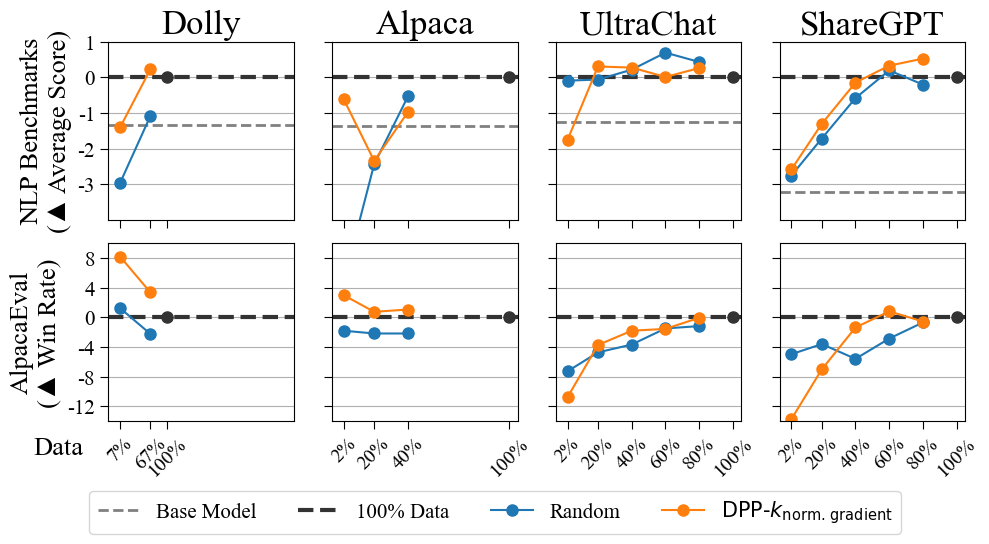

In [364]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
font_path = '/dccstor/data-pruning/miniconda3/pkgs/mscorefonts-0.0.1-3/fonts/times.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()


from collections import defaultdict

def get_task_name_display(task_name):
    if task_name == 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/WR*': return 'AlpacaEval\n(Win Rate)'
    elif task_name == 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Len*': return 'AlpacaEval\n(Tok Length*)'
    elif task_name == 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/Len': return 'AlpacaEval\n(Tok Length)'
    elif task_name == 'AlpacaFarm(alpaca:eval:gpt4:turbo:fn)/LenMed': return 'AlpacaEval\n(Medium #Tokens)'
    elif task_name == 'MTBench(gpt:4)/Turn-1': return 'MT-Bench(GPT-4)/Turn-1'
    elif task_name == 'MTBench(gpt:4)/Turn-2': return 'MT-Bench(GPT-4)/Turn-2'
    elif task_name == 'MTBench(gpt:4)/Rating': return 'MT-Bench(GPT-4)/Rating'
    elif task_name == 'nonchat': return 'NLP Benchmarks\n(Average Score)'
    else: return task_name
        
def get_dataset_display(dataset):
    if 'dolly' in dataset: return 'Dolly'
    elif 'stanford_alpaca' in dataset: return 'Alpaca'
    elif 'ultrachat' in dataset: return 'UltraChat'
    elif 'sharegpt' in dataset: return 'ShareGPT'
    elif 'ultrafeedback' in dataset: return 'UltraFeedback'
    else: raise ValueError(f'{dataset} not defined display name')


data_to_compute_dict = dfc.set_index(['subset_size']).to_dict()['compute']
data_to_compute_pct = lambda x: data_to_compute_dict[x]/max(data_to_compute_dict.values())*100


plt_base_model = True
plt_full_finetune = True
xaxis_type = 'data' # 'compute'
yaxis_type = 'abs'
yaxis_type = 'delta_fullfinetune'; 
assert(yaxis_type in ['abs', 'delta_fullfinetune'])

if finetune_type == 'sft':
    datasets = ['dolly', 'stanford_alpaca50k', 'ultrachat50k', 'sharegpt50k']
    # datasets = ['flan_v250k', 'dolly', 'stanford_alpaca50k', 'oasst2', 'ultrachat50k', 'wizardlm50k', 'sharegpt50k']
else:
    datasets = ['ultrafeedback']
# datasets = list(np.unique(dfc['dataset']))

task_names = []
task_names += ['nonchat']
# task_names += ['nonchat', 'MMLU/0-shot', 'GSM/CoT', 'BBH/Direct', 'TydiQA/GP', 'Codex-Eval/Pass@1', 'AlpacaFarm/WR*',]
# task_names += ['MMLU/0-shot', 'GSM/CoT', 'BBH/Direct', 'TydiQA/GP', 'Codex-Eval/Pass@1',]
# task_names += [f'MTBench({mtbench_judge})/Turn-1',  f'MTBench({mtbench_judge})/Turn-2', f'MTBench({mtbench_judge})/Rating']
# task_names += [f'MTBench({mtbench_judge})/Rating']
# task_names += [f'MTBench({mtbench_judge})/Turn-1']
task_names += [f'AlpacaFarm({alpacafarm_judge})/WR*'] 
# task_names += [f'AlpacaFarm({alpacafarm_judge})/WR*', f'AlpacaFarm({alpacafarm_judge})/LenMed'] # , f'AlpacaFarm({alpacafarm_judge})/Rep2'

label_baseline = 'Base Model'

plt_settings = {
    'color': {
        full_sft_short: '#333333', #'#FFA500', # orange
#         'Random': 'gray',
        label_baseline: 'gray',
#         label_dpp_vmf_grad: '#3498db', # bright blue
#         label_dpp_vmf_text: '#1f618d', # dark blue
#         label_dpp_vmf_text,
#         label_dpp_rbf_grad,
#         label_dpp_rbf_text,
    },
    
    
}

plt.rcParams.update({
    'axes.titlesize': 25,   # ax title
    'axes.labelsize': 19,   # labels (x-axis and y-axis)
    'xtick.labelsize': 14,  # xtick size
    'ytick.labelsize': 15,  # ytick size
    'figure.labelsize': 25, # 
    'legend.fontsize': 15,  # legend font size
})

markers_list = ['^', 'o', '*', 'x', 's', ]
markers_list = ['o']*10
lineplot_kwargs = {'marker': '.', 
#                    'markerfacecolor': 'none', 
                   'markersize': 8, 
#                    'markeredgewidth': 2,
#                    'linewidth': 1.5,
                  }

w = 2.5; h = 2.5
# w = 3; h = 3
ncols = len(datasets)
nrows = len(task_names)
fig, axs = plt.subplots(nrows, ncols, figsize=(w*ncols, h*nrows), sharey='row', sharex='col')

xticks_data = defaultdict(list)

for axi, task_name in enumerate(task_names):
    d = D[task_name]
    for axj, dataset in enumerate(datasets):
        ax = axs.reshape(nrows, ncols)[axi, axj]
        dataset_size = get_dataset_size(dataset)
        is_first_subfig = (axi==0 and axj==0)

        if plt_base_model and task_name == 'nonchat':
            k = DKey(full_sft_short, dataset, dataset_size)
            if k in d:
                y_fullfinetune = d[k]
                y_base = base_model_perf[task_name]
                y = y_base-y_fullfinetune if yaxis_type == 'delta_fullfinetune' else y_base
                ax.axhline(y=y, linestyle='--', color=plt_settings['color'][label_baseline], label=label_baseline if is_first_subfig else None, linewidth=2)
        if plt_full_finetune:
            k = DKey(full_sft_short, dataset, dataset_size)
            if k in d:
                y = 0 if yaxis_type == 'delta_fullfinetune' else d[k]
                ax.axhline(y=y, linestyle='--', color=plt_settings['color'][full_sft_short], label=full_sft_short if is_first_subfig else None, linewidth=3)

        sort_by_types = sorted(set(x.sort_by_type for x in d.keys()))[::-1]
#         sort_by_types = list(set([x.sort_by_type for x in d.keys()]))
        for i, sort_by_type in enumerate(sort_by_types):
            xs = sorted([x.subset_size for x in d.keys()
                         if x.dataset == dataset and x.sort_by_type==sort_by_type])
            xticks_data[dataset] += list(set(xs) - set(xticks_data[dataset]))

            ys = [d[DKey(sort_by_type, dataset, x)] for x in xs]
            if yaxis_type == 'delta_random':
                if not all(DKey('random', dataset, x) in d for x in xs): continue
                ys = [y-d[DKey('random', dataset, x)] for x, y in zip(xs, ys)] 
            elif yaxis_type == 'delta_fullfinetune':
                if DKey(full_sft_short, dataset, dataset_size) not in d: continue
                ys = [y-d[DKey(full_sft_short, dataset, dataset_size)] for y in ys]
            kwargs = {}
            if sort_by_type in plt_settings['color']:
                kwargs['color'] = plt_settings['color'][sort_by_type]
            if full_sft_short not in sort_by_type and is_first_subfig:
                kwargs['label'] = sort_by_type
            kwargs.update(lineplot_kwargs)
            kwargs.update({'marker': markers_list[i]})
            xs = xs if xaxis_type == 'data' else [data_to_compute_pct(x) for x in xs]
            ax.plot(xs, ys, **kwargs)
            ax.grid(visible=True, axis='y')
            ax.tick_params(axis='both', which='both', length=6) 


## left most subfigure set ylabel & yticks
for axi, task_name in enumerate(task_names):
    task_name_shortened = get_task_name_display(task_name)
    ax = axs.reshape(nrows, ncols)[axi, 0]
    ax.set_ylabel(task_name_shortened.replace('(', '(▲ ') if yaxis_type.startswith('delta') else task_name_shortened, va='bottom')
    if yaxis_type == 'delta_fullfinetune':
        if task_name == 'nonchat': yticks = [-3,-2,-1,0,1]
        elif 'AlpacaFarm' in  task_name: yticks = [-12, -8, -4, 0, 4, 8]
        else: yticks = None
        if yticks is not None: ax.set_yticks(yticks, yticks)
    

for axj, dataset in enumerate(datasets):
    dataset_size = get_dataset_size(dataset)
    xticks = np.array(sorted(xticks_data[dataset]))
    ax = axs.reshape(nrows, ncols)[nrows-1, axj]
    c = .05; ax.set_xlim((-N*c, N+c*N))
    xticklabels = [f'{x*100:.0f}%' for x in xticks/get_dataset_size(dataset)]
    ax.set_xticks(xticks, xticklabels, ha='center', rotation=45)

    ax = axs.reshape(nrows, ncols)[0, axj]
    ax.set_title(get_dataset_display(dataset))

    if yaxis_type != 'abs':
        axs.reshape(nrows, ncols)[0, axj].set_ylim((-3.5, 1))
        axs.reshape(nrows, ncols)[1, axj].set_ylim((-14, 10))
        
## data xlabel at the side s
axs.reshape(nrows, ncols)[nrows-1, 0].annotate('Data', xy=(-0.4, -.15), xycoords="axes fraction", ha='left', va='center', weight='bold', fontsize=plt.rcParams['axes.labelsize'])
## legend at bottom
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -.1), ncol=4, frameon=True)


fig.tight_layout()

save_path = os.path.join(assets_dir, 'fig_vmf_grad_vs_random_cross_datasets.pdf')
fig.savefig(save_path, bbox_inches='tight', dpi=100)